# 1. Import packages and load data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier

# import logistic regression libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, auc

# import classification tree libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree

# import random forest libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# import cross validation libraries
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

In [5]:
# load data
df = pd.read_csv(r"C:\Users\woowe\Downloads\hospital_readmissions.csv")
print(df.head())

       age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 8                72             1             18   
1  [70-80)                 3                34             2             13   
2  [50-60)                 5                45             0             18   
3  [70-80)                 2                36             0             12   
4  [60-70)                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
0             2            0            0           Missing  Circulatory   
1             0            0            0             Other        Other   
2             0            0            0           Missing  Circulatory   
3             1            0            0           Missing  Circulatory   
4             0            0            0  InternalMedicine        Other   

        diag_2       diag_3 glucose_test A1Ctest change diabetes_med

## Exploratory Data Analysis 

### Data quantity

In [8]:
print("The raw dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))

The raw dataset has 25000 rows and 17 columns


### Null values

In [10]:
# check null values
missing_counts = df.isnull().sum()
print("Count of Missing Values")
print(missing_counts)

Count of Missing Values
age                  0
time_in_hospital     0
n_lab_procedures     0
n_procedures         0
n_medications        0
n_outpatient         0
n_inpatient          0
n_emergency          0
medical_specialty    0
diag_1               0
diag_2               0
diag_3               0
glucose_test         0
A1Ctest              0
change               0
diabetes_med         0
readmitted           0
dtype: int64


### Data types

In [12]:
# check data types
df.dtypes

age                  object
time_in_hospital      int64
n_lab_procedures      int64
n_procedures          int64
n_medications         int64
n_outpatient          int64
n_inpatient           int64
n_emergency           int64
medical_specialty    object
diag_1               object
diag_2               object
diag_3               object
glucose_test         object
A1Ctest              object
change               object
diabetes_med         object
readmitted           object
dtype: object

### Univariate Distribution

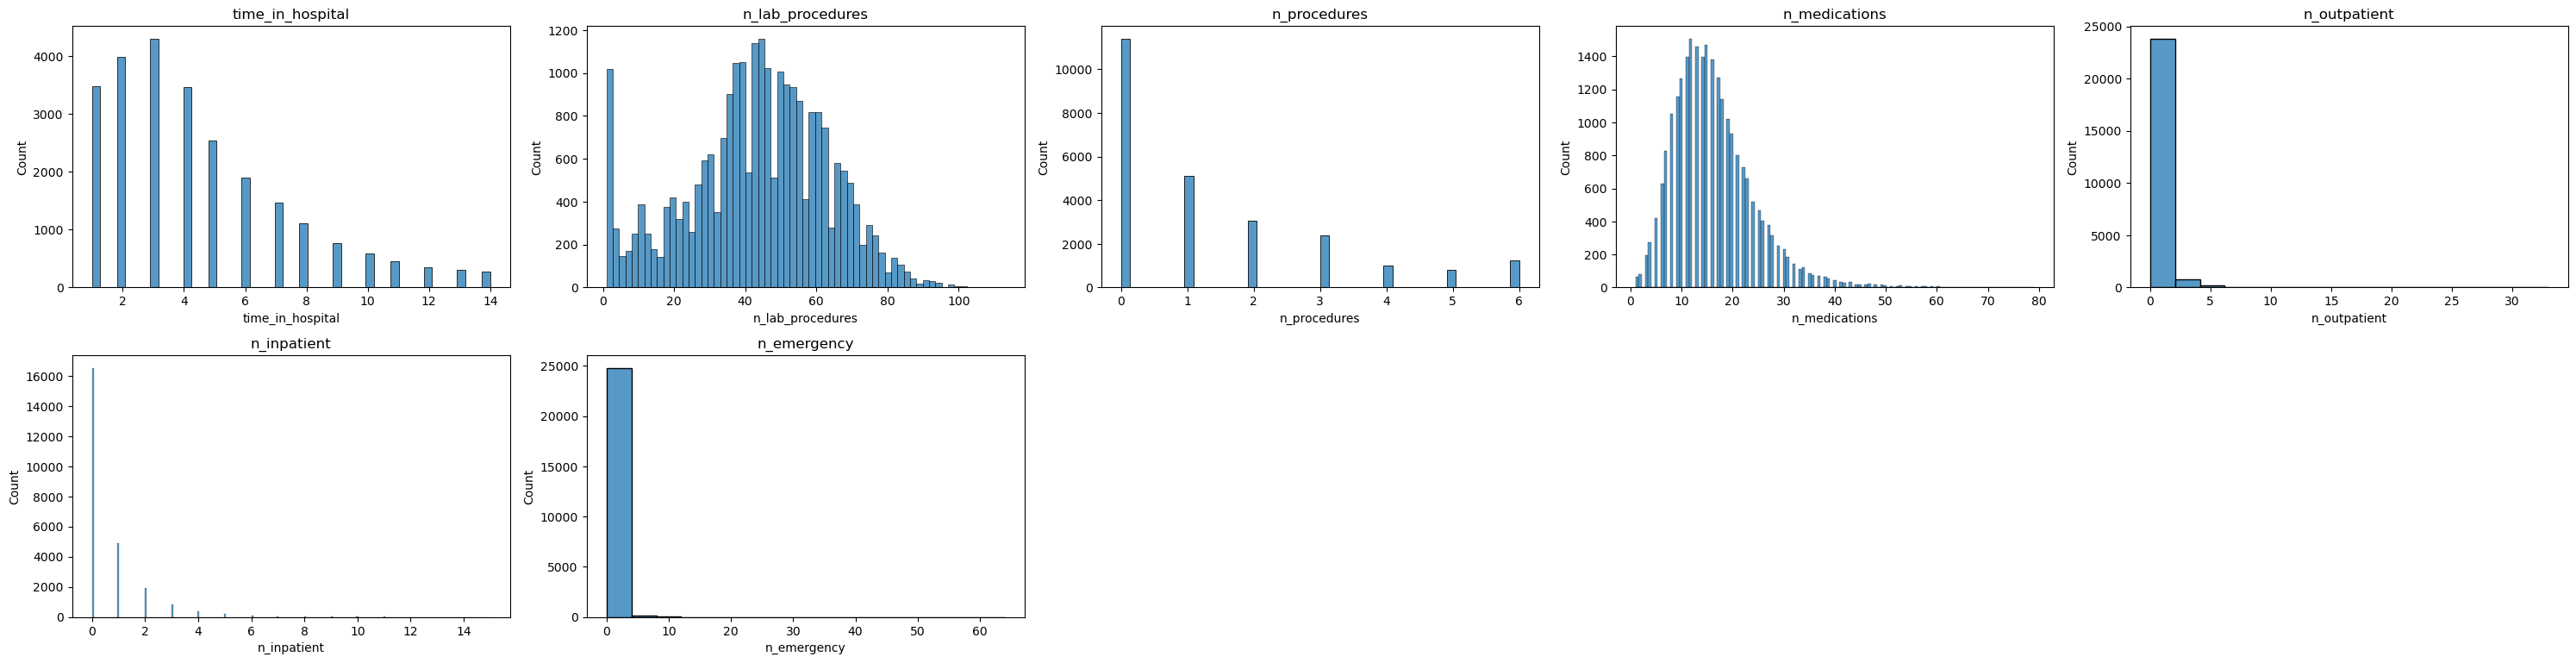

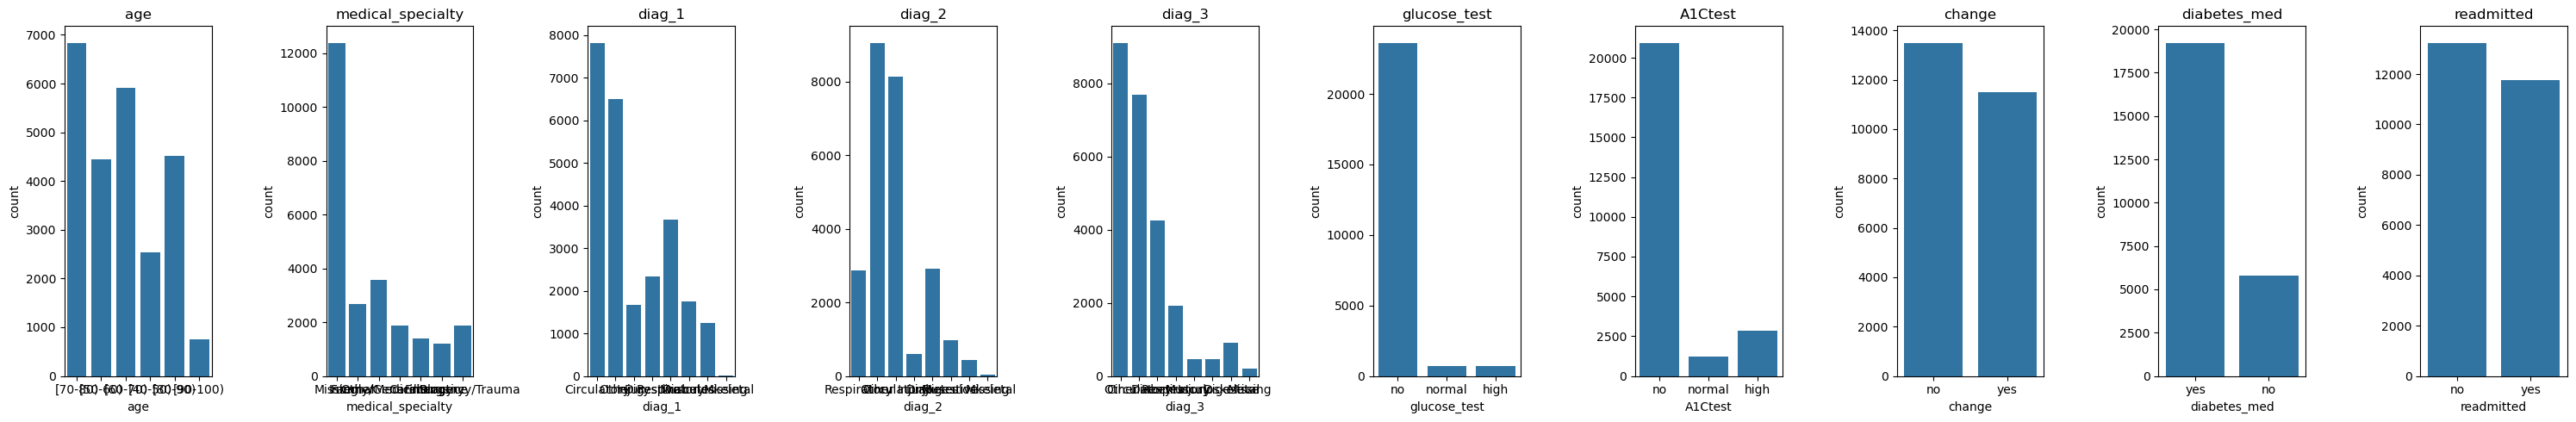

In [14]:
# EDA on the entire raw dataset
# Define numeric and categorical columns for EDA
num_columns = df.select_dtypes(include=['int64']).columns.tolist()
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

# Plot numeric feature distributions
plt.figure(figsize=(30, 15))
for i, column in enumerate(num_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column], kde=False)
    plt.title(column)
plt.tight_layout()
plt.show()

# Plot categorical feature distributions
plt.figure(figsize=(30, 5))
for i, column in enumerate(cat_columns, 1):
    plt.subplot(1, len(cat_columns), i)
    sns.countplot(x=column, data=df)
    plt.title(column)
plt.tight_layout()
plt.show()

### Summary table

In [16]:
# summary table of dataset
df.describe()

time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
count       25000.00000       25000.00000  25000.000000   25000.000000   
mean            4.45332          43.24076      1.352360      16.252400   
std             3.00147          19.81862      1.715179       8.060532   
min             1.00000           1.00000      0.000000       1.000000   
25%             2.00000          31.00000      0.000000      11.000000   
50%             4.00000          44.00000      1.000000      15.000000   
75%             6.00000          57.00000      2.000000      20.000000   
max            14.00000         113.00000      6.000000      79.000000   

       n_outpatient   n_inpatient   n_emergency  
count  25000.000000  25000.000000  25000.000000  
mean       0.366400      0.615960      0.186600  
std        1.195478      1.177951      0.885873  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.000000      1.000000      0.000000  
max       33.000000     15.000000     64.000000

### Check outliers

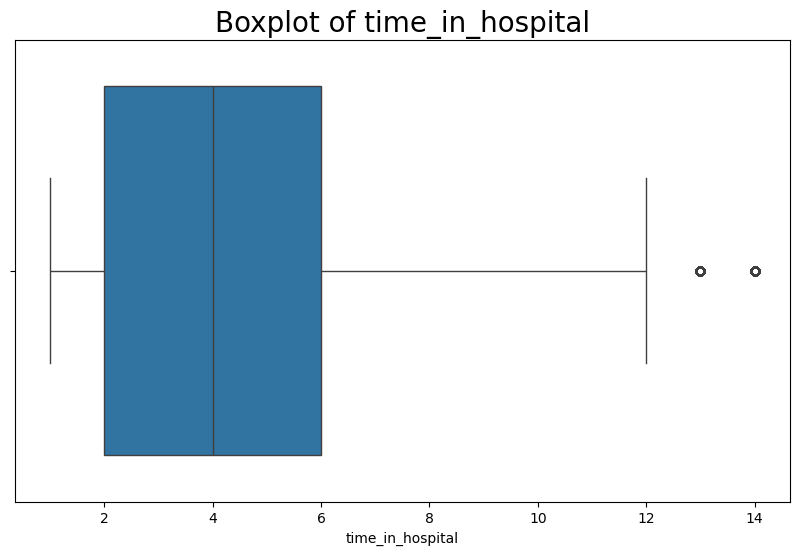

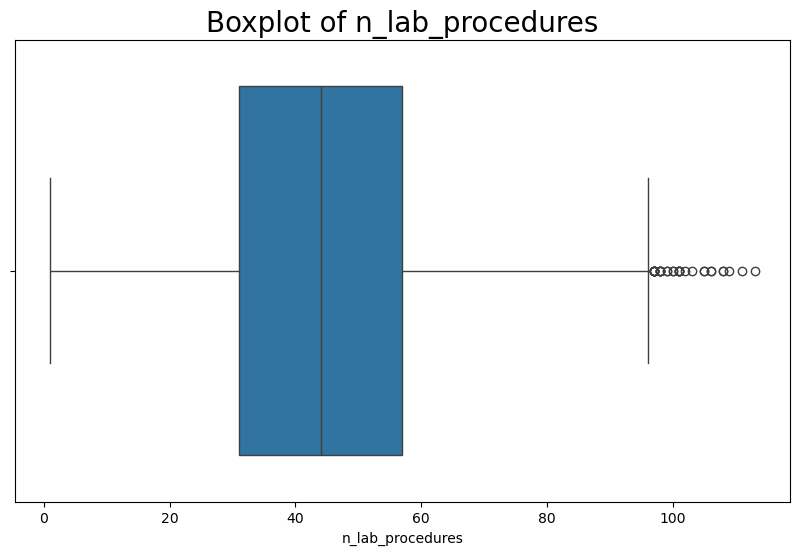

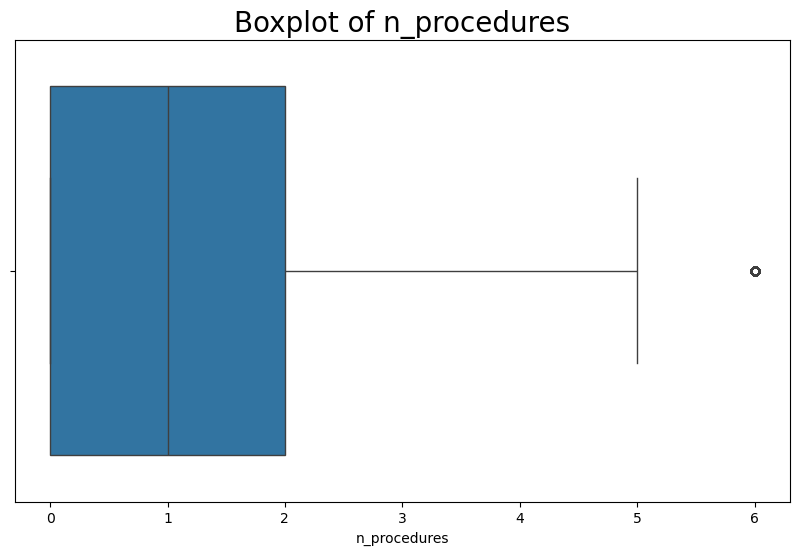

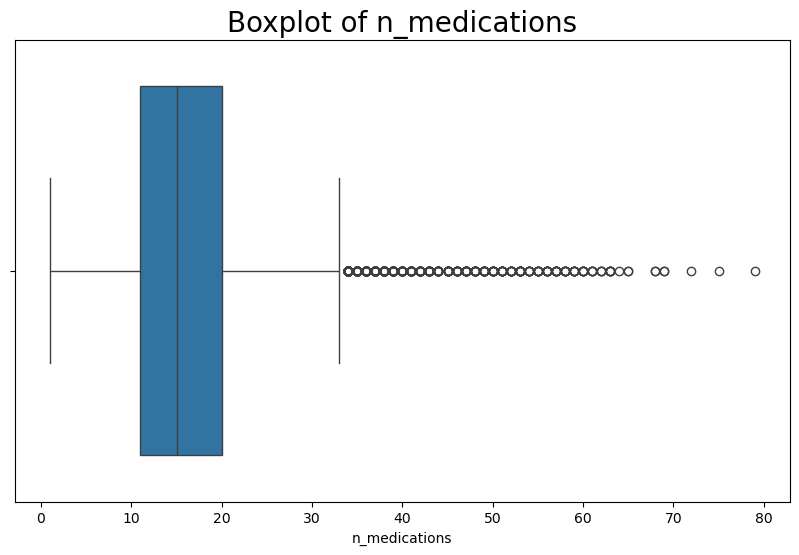

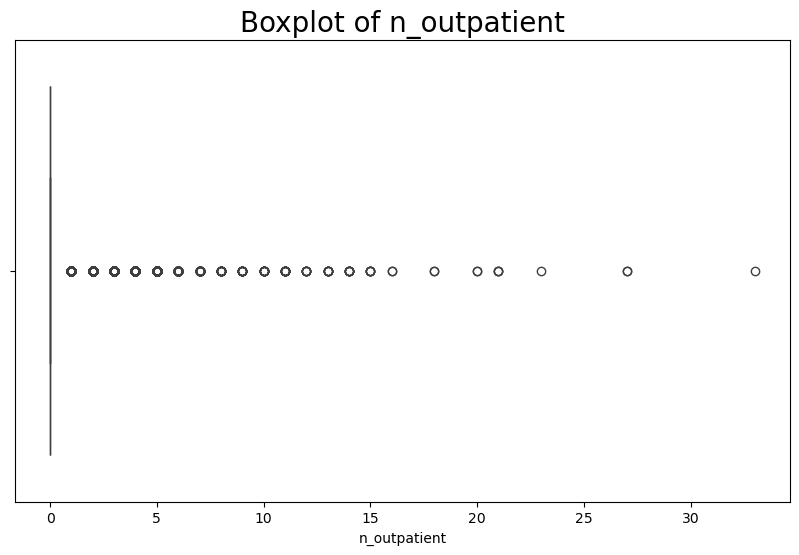

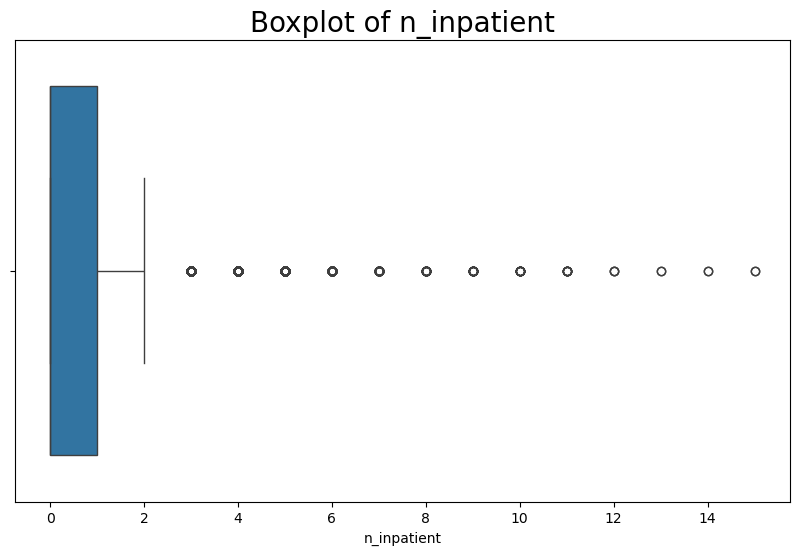

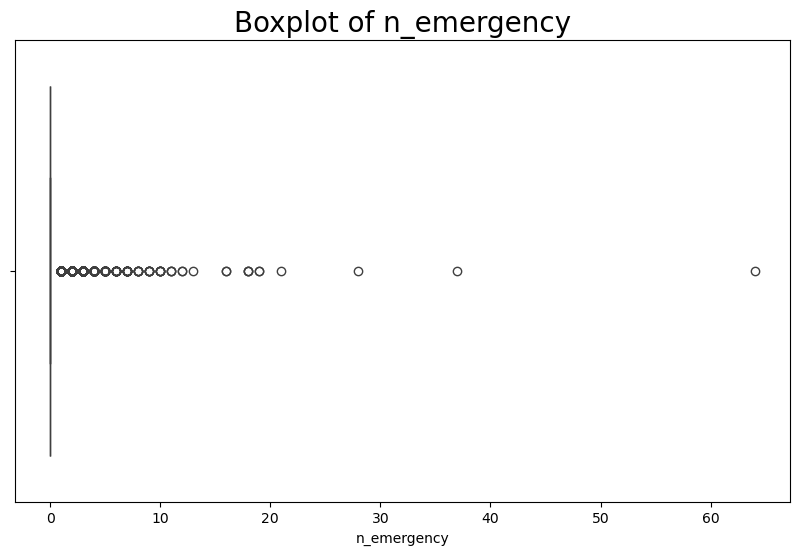

In [18]:
# check outliers
for column in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 6))  # Set figure size for each plot
    sns.boxplot(x=df[column])  # Create boxplot
    plt.title(f"Boxplot of {column}", fontdict={'fontsize': 20})  # Set title
    plt.xlabel(column)  # Label x-axis
    plt.show()  # Display the plot

We noted that there were many outliers for `n_lab_procedures`, `n_medications`, `n_outpatient`, `n_inpatient` and `n_emergency`. However, since they are not data entry mistakes and are valid values, we decided to keep them.

# 2. Feature Engineering

### Create interaction term 'severity'
<ul>
    <li>The new column severity reflects the interaction between time spent in the hospital and the combined number of lab and medical procedures.</li>
    <li>A higher value of severity could indicate a more serious condition, as it implies that patients with longer hospital stays and more procedures are likely to have greater health complexities.</li>
    <li>The term 32 * df['n_procedures'] adds a weighted contribution of the number of procedures, suggesting that each procedure has a significant impact on the overall severity.</li>
 </ul>

In [22]:
# create interaction term 'severity'
df_new = df.copy()
df_new['severity'] = df_new['time_in_hospital'] * (df_new['n_lab_procedures'] + 32 * df_new['n_procedures'])

### Transform existing variables
* For `time_in_hospital` which is right-skewed, we apply a regular natural log transform: The transformed variable is named `log_time_in_hospital`.

* For `n_procedures` which is right-skewed, we apply a regular natural log transform: The transformed variable is named `log_n_procedures`.

* For `n_inpatient` which is right-skewed, we apply a regular natural log transform: The transformed variable is named `log_n_inpatient`.

In [24]:
# Apply a log transform to existing variables
df_new["log_time_in_hospital"] = np.log1p(df_new["time_in_hospital"])
df_new["log_n_procedures"] = np.log1p(df_new["n_procedures"])
df_new["log_n_inpatient"] = np.log1p(df_new["n_inpatient"])

# Drop the original columns to prevent multicollinearity issues
df_new.drop(["time_in_hospital", "n_procedures", "n_inpatient"], axis = 1, inplace = True)


In [25]:
df_new.head()

age  n_lab_procedures  n_medications  n_outpatient  n_emergency  \
0  [70-80)                72             18             2            0   
1  [70-80)                34             13             0            0   
2  [50-60)                45             18             0            0   
3  [70-80)                36             12             1            0   
4  [60-70)                42              7             0            0   

  medical_specialty       diag_1       diag_2       diag_3 glucose_test  \
0           Missing  Circulatory  Respiratory        Other           no   
1             Other        Other        Other        Other           no   
2           Missing  Circulatory  Circulatory  Circulatory           no   
3           Missing  Circulatory        Other     Diabetes           no   
4  InternalMedicine        Other  Circulatory  Respiratory           no   

  A1Ctest change diabetes_med readmitted  severity  log_time_in_hospital  \
0      no     no          yes         no       832              2.197225   
1      no     no          yes         no       294              1.386294   
2      no    yes          yes        yes       225              1.791759   
3      no    yes          yes        yes        72              1.098612   
4      no     no          yes         no        42              0.693147   

   log_n_procedures  log_n_inpatient  
0          0.693147              0.0  
1          1.098612              0.0  
2          0.000000              0.0  
3          0.000000              0.0  
4          0.000000              0.0

## Exploratory Data Analysis (Processed Data)

### Data types

In [28]:
# check data types
df_new.dtypes

age                      object
n_lab_procedures          int64
n_medications             int64
n_outpatient              int64
n_emergency               int64
medical_specialty        object
diag_1                   object
diag_2                   object
diag_3                   object
glucose_test             object
A1Ctest                  object
change                   object
diabetes_med             object
readmitted               object
severity                  int64
log_time_in_hospital    float64
log_n_procedures        float64
log_n_inpatient         float64
dtype: object

### Univariate Distribution

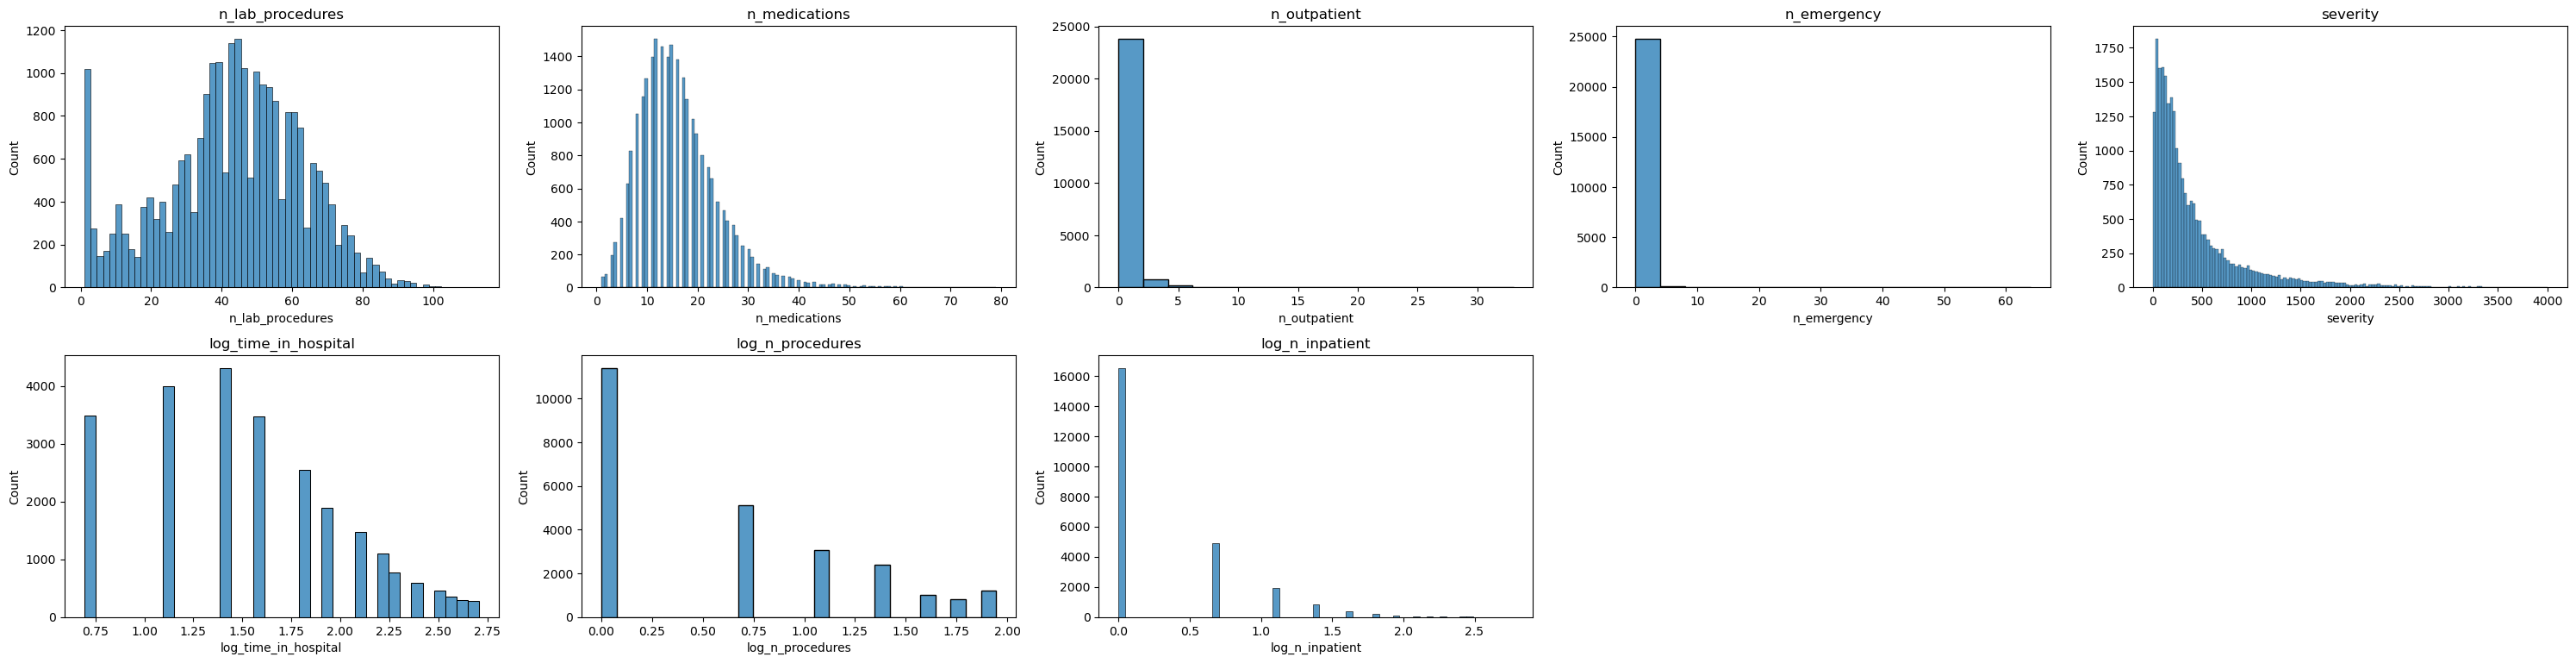

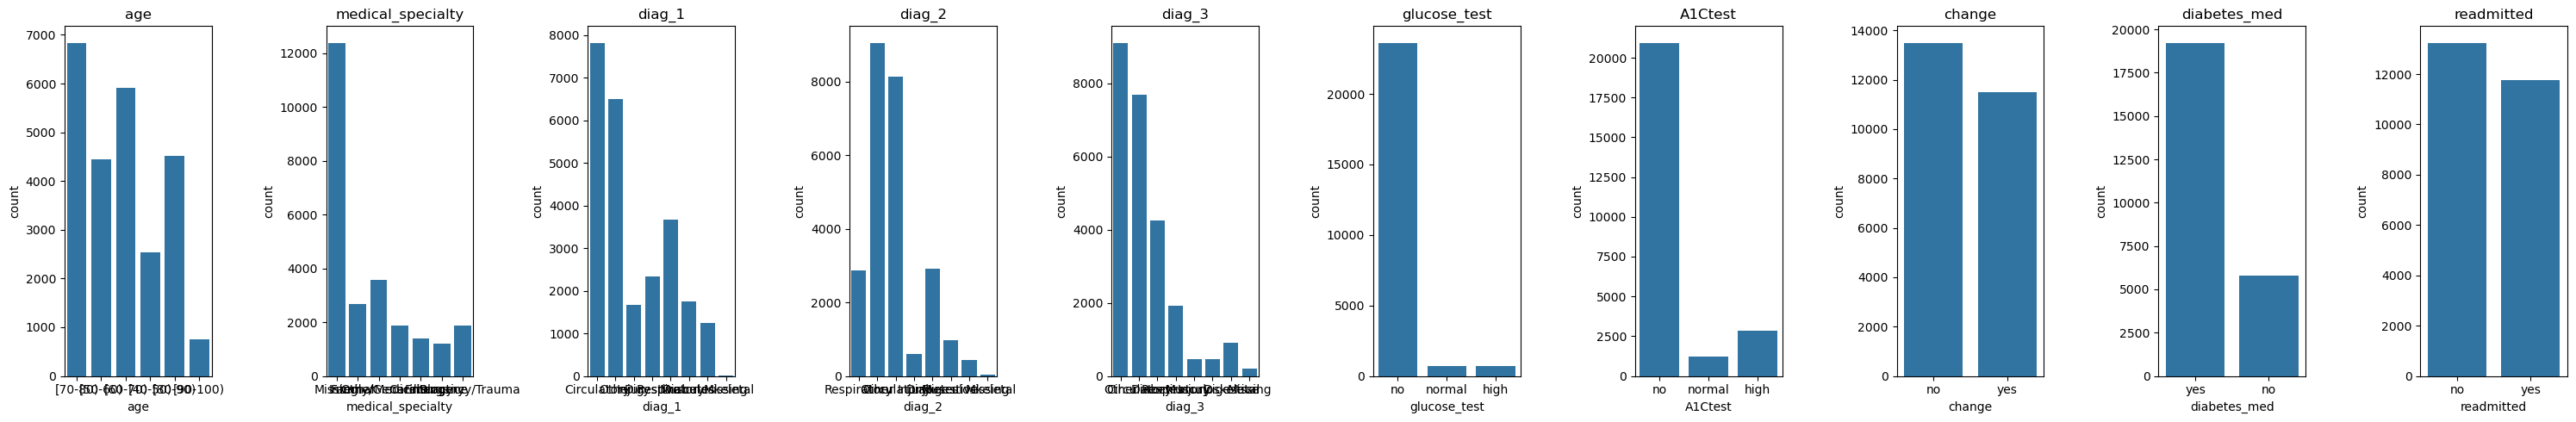

In [30]:
# EDA on the entire raw dataset
# Define numeric and categorical columns for EDA
num_columns_new = df_new.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_columns_new = df_new.select_dtypes(include=['object']).columns.tolist()

# Plot numeric feature distributions
plt.figure(figsize=(30, 15))
for i, column in enumerate(num_columns_new, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df_new[column], kde=False)
    plt.title(column)
plt.tight_layout()
plt.show()

# Plot categorical feature distributions
plt.figure(figsize=(30, 5))
for i, column in enumerate(cat_columns_new, 1):
    plt.subplot(1, len(cat_columns_new), i)
    sns.countplot(x=column, data=df)
    plt.title(column)
plt.tight_layout()
plt.show()

### Summary table

In [32]:
# summary table of dataset
df_new.describe()

n_lab_procedures  n_medications  n_outpatient   n_emergency  \
count       25000.00000   25000.000000  25000.000000  25000.000000   
mean           43.24076      16.252400      0.366400      0.186600   
std            19.81862       8.060532      1.195478      0.885873   
min             1.00000       1.000000      0.000000      0.000000   
25%            31.00000      11.000000      0.000000      0.000000   
50%            44.00000      15.000000      0.000000      0.000000   
75%            57.00000      20.000000      0.000000      0.000000   
max           113.00000      79.000000     33.000000     64.000000   

           severity  log_time_in_hospital  log_n_procedures  log_n_inpatient  
count  25000.000000          25000.000000      25000.000000     25000.000000  
mean     434.342320              1.553614          0.626528         0.323864  
std      519.559753              0.535475          0.656202         0.500605  
min        1.000000              0.693147          0.000000         0.000000  
25%      116.000000              1.098612          0.000000         0.000000  
50%      250.000000              1.609438          0.693147         0.000000  
75%      537.500000              1.945910          1.098612         0.693147  
max     4004.000000              2.708050          1.945910         2.772589

### Check outliers

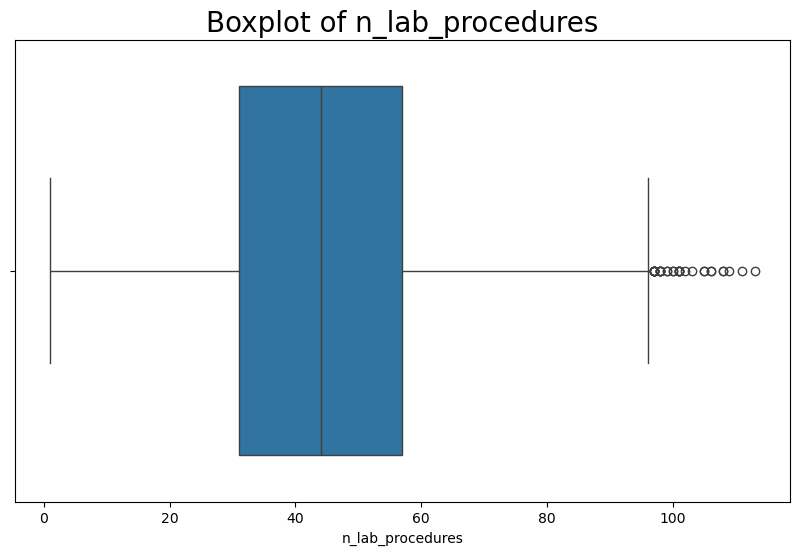

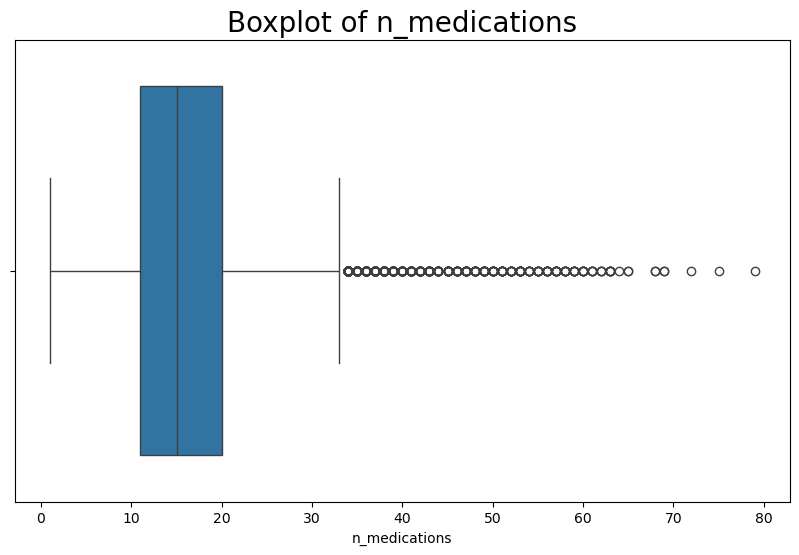

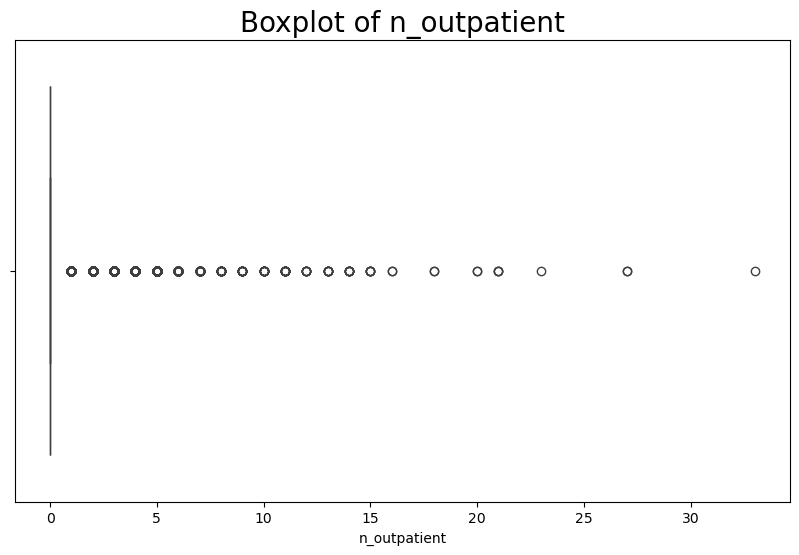

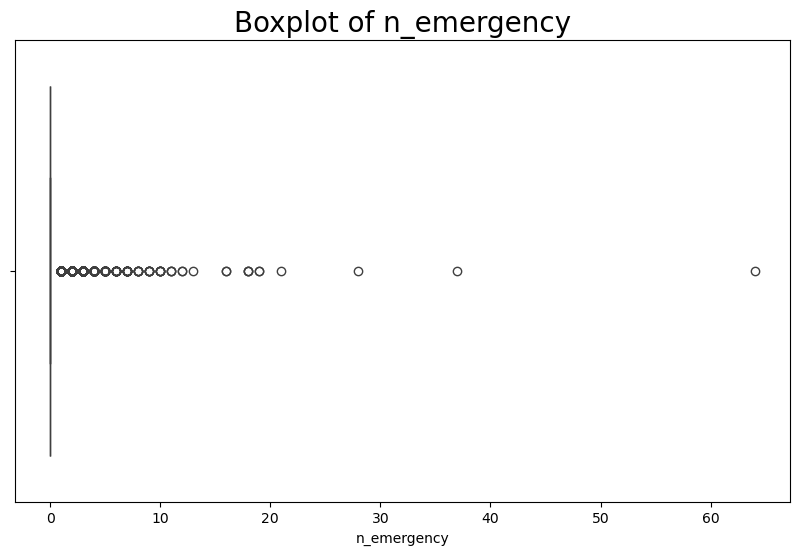

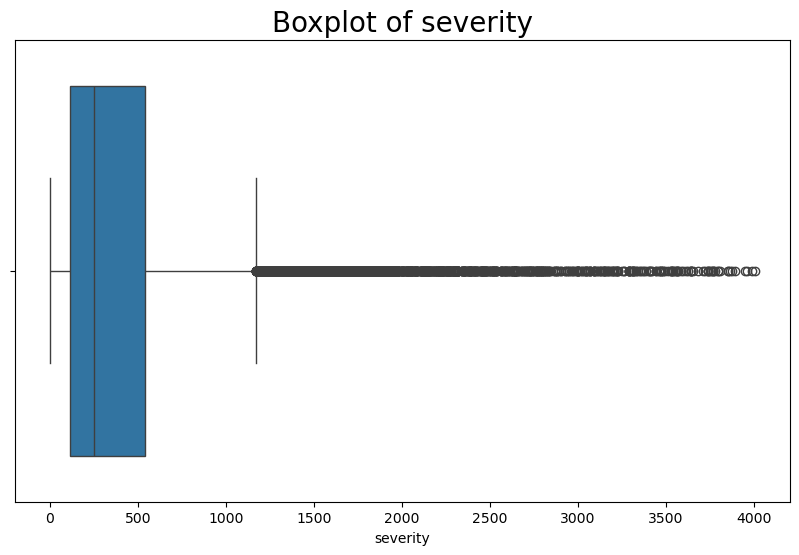

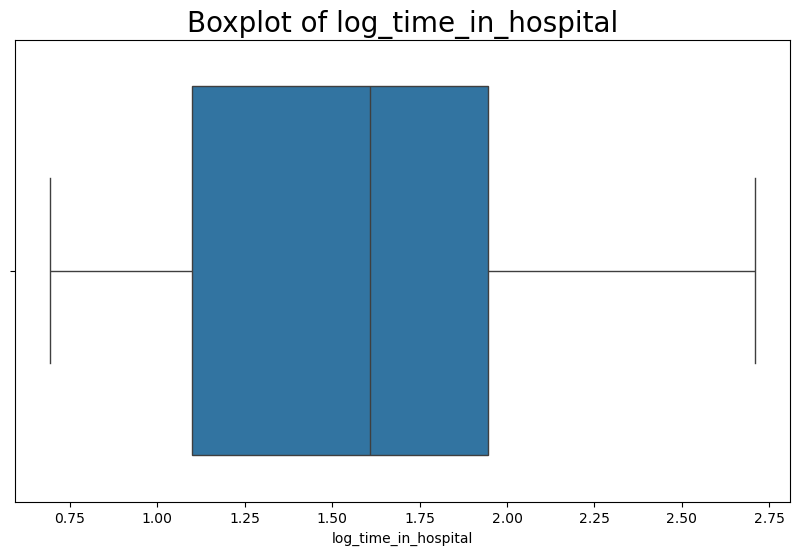

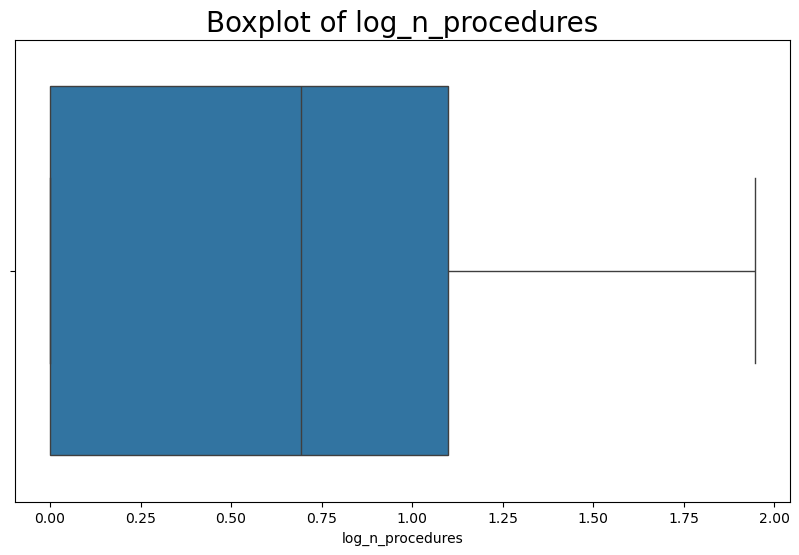

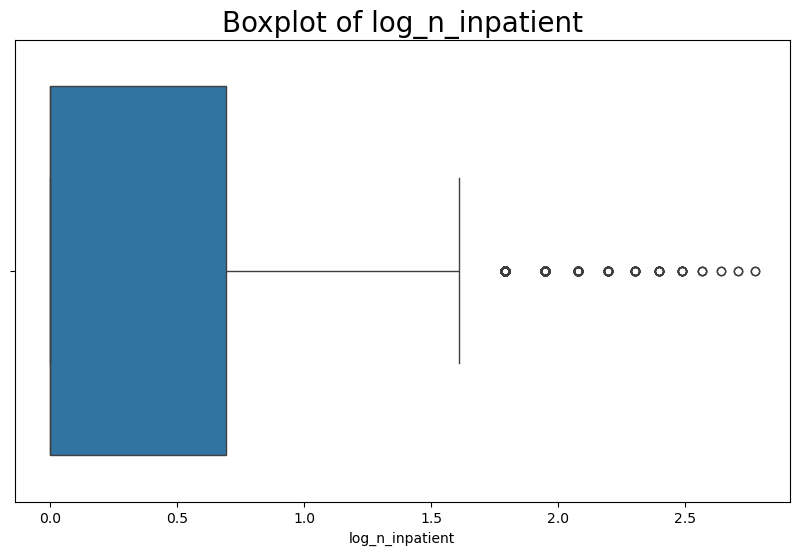

In [34]:
# check outliers
for column in df_new.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 6))  # Set figure size for each plot
    sns.boxplot(x=df_new[column])  # Create boxplot
    plt.title(f"Boxplot of {column}", fontdict={'fontsize': 20})  # Set title
    plt.xlabel(column)  # Label x-axis
    plt.show()  # Display the plot

# 3. Data preprocessing

### One-hot encoding

In [37]:
# one-hotting independent variables
df2 = pd.get_dummies(df_new, columns = ['diabetes_med'], drop_first = True, dtype = int)
df3 = pd.get_dummies(df2, columns = ['age'], drop_first = True, dtype = int)
df4 = pd.get_dummies(df3, columns = ['medical_specialty'], drop_first = True, dtype = int)
df5 = pd.get_dummies(df4, columns = ['diag_1'], drop_first = True, dtype = int)
df6 = pd.get_dummies(df5, columns = ['diag_2'], drop_first = True, dtype = int)
df7 = pd.get_dummies(df6, columns = ['diag_3'], drop_first = True, dtype = int)
df8 = pd.get_dummies(df7, columns = ['glucose_test'], drop_first = True, dtype = int)
df9 = pd.get_dummies(df8, columns = ['A1Ctest'], drop_first = True, dtype = int)
df10 = pd.get_dummies(df9, columns = ['change'], drop_first = True, dtype = int)

# one-hot readmission variable
df11 = pd.get_dummies(df10, columns = ['readmitted'], drop_first = True, dtype = int)
print(df11.head())

   n_lab_procedures  n_medications  n_outpatient  n_emergency  severity  \
0                72             18             2            0       832   
1                34             13             0            0       294   
2                45             18             0            0       225   
3                36             12             1            0        72   
4                42              7             0            0        42   

   log_time_in_hospital  log_n_procedures  log_n_inpatient  diabetes_med_yes  \
0              2.197225          0.693147              0.0                 1   
1              1.386294          1.098612              0.0                 1   
2              1.791759          0.000000              0.0                 1   
3              1.098612          0.000000              0.0                 1   
4              0.693147          0.000000              0.0                 1   

   age_[50-60)  ...  diag_3_Missing  diag_3_Musculoskeletal  diag_3_

### Train-test split

In [39]:
# define feature names for x and y datasets
# remove '[' for xgboost model to run successfully
y_name=['readmitted_yes']
x_name=['n_lab_procedures', 'n_medications', 'n_outpatient', 'n_emergency',
       'severity', 'log_time_in_hospital', 'log_n_procedures',
       'log_n_inpatient', 'diabetes_med_yes', 'age_50-60)', 'age_60-70)',
       'age_70-80)', 'age_80-90)', 'age_90-100)',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Missing',
       'medical_specialty_Other', 'medical_specialty_Surgery',
       'diag_1_Diabetes', 'diag_1_Digestive', 'diag_1_Injury',
       'diag_1_Missing', 'diag_1_Musculoskeletal', 'diag_1_Other',
       'diag_1_Respiratory', 'diag_2_Diabetes', 'diag_2_Digestive',
       'diag_2_Injury', 'diag_2_Missing', 'diag_2_Musculoskeletal',
       'diag_2_Other', 'diag_2_Respiratory', 'diag_3_Diabetes',
       'diag_3_Digestive', 'diag_3_Injury', 'diag_3_Missing',
       'diag_3_Musculoskeletal', 'diag_3_Other', 'diag_3_Respiratory',
       'glucose_test_no', 'glucose_test_normal', 'A1Ctest_no',
       'A1Ctest_normal', 'change_yes']

In [40]:
# define features (X) and target (y)
df_X = df11.iloc[:, :-1] # drop 'readmitted_yes'
df_y = df11.iloc[:, -1:] # only store 'readmitted_yes'

# split data points (rows) into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.2, random_state = 42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled features back to DataFrame
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=x_name).reset_index(drop=True)
df_X_test_scaled = pd.DataFrame(X_test_scaled, columns=x_name).reset_index(drop=True)

df_y_train = pd.DataFrame(y_train, columns=y_name).reset_index(drop=True)
df_y_test = pd.DataFrame(y_test, columns=y_name).reset_index(drop=True)

df_train = pd.concat([df_X_train_scaled, df_y_train], axis = 1)
df_test = pd.concat([df_X_test_scaled, df_y_test], axis = 1)

To check any null values in final datasets

In [42]:
df_train.isnull().sum()

n_lab_procedures                            0
n_medications                               0
n_outpatient                                0
n_emergency                                 0
severity                                    0
log_time_in_hospital                        0
log_n_procedures                            0
log_n_inpatient                             0
diabetes_med_yes                            0
age_50-60)                                  0
age_60-70)                                  0
age_70-80)                                  0
age_80-90)                                  0
age_90-100)                                 0
medical_specialty_Emergency/Trauma          0
medical_specialty_Family/GeneralPractice    0
medical_specialty_InternalMedicine          0
medical_specialty_Missing                   0
medical_specialty_Other                     0
medical_specialty_Surgery                   0
diag_1_Diabetes                             0
diag_1_Digestive                  

In [43]:
df_test.isnull().sum()

n_lab_procedures                            0
n_medications                               0
n_outpatient                                0
n_emergency                                 0
severity                                    0
log_time_in_hospital                        0
log_n_procedures                            0
log_n_inpatient                             0
diabetes_med_yes                            0
age_50-60)                                  0
age_60-70)                                  0
age_70-80)                                  0
age_80-90)                                  0
age_90-100)                                 0
medical_specialty_Emergency/Trauma          0
medical_specialty_Family/GeneralPractice    0
medical_specialty_InternalMedicine          0
medical_specialty_Missing                   0
medical_specialty_Other                     0
medical_specialty_Surgery                   0
diag_1_Diabetes                             0
diag_1_Digestive                  

# 4. Model Training

K-fold cross validation is used since there is no class imbalance issue for our target variable.

In [46]:
# K-fold CV splitter
kf10 = KFold(n_splits = 10, shuffle = True, random_state = 42)

In [47]:
# Manually generate CV folds
def get_CV_folds(df, y, X, cv):
    train, val = [], []
    for train_index, val_index in cv.split(df[X], df[y]):
        train.append(df.loc[train_index])
        val.append(df.loc[val_index])
    return train, val

In [48]:
# Report GridSearchCV results
def report_GridSearchCV_results(grid):
    print("- Best combination of hyperparams:\n", grid.best_params_, "\n")
    print("- Best mean_test_score:\n", grid.best_score_, "\n")
    
    scores = []
    for i in range(grid.n_splits_):
        scores.append(grid.cv_results_['split{}_test_score'.format(i)][grid.best_index_])
    print("- Score by fold for best estimator:\n", scores, "\n")
    
    # View top 10 hyperparameter combinations by mean_test_score (mean AUC on validation set)
    print("- Top 10 hyperparameter combinations by mean_test_score:")
    display(pd.DataFrame(grid.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in grid.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(10))
    
    return None

In [49]:
# Compare training dataset performance vs validation dataset performance
def compare_performance(grid):  
    # retrieve training and validation scores
    train_scores=grid.cv_results_['mean_train_score']
    val_scores=grid.cv_results_['mean_test_score']

    # limit to 10 rows
    train_scores_limited=train_scores[:10]
    val_scores_limited=val_scores[:10]
    
    # create dataframe to store scores
    all_scores=pd.DataFrame({
    "train_AUC": train_scores_limited, 
    "val_AUC": val_scores_limited
    }, index=range(1,11))

    mean_scores=pd.DataFrame({
        "train_AUC": [train_scores_limited.mean()],
        "val_AUC": [val_scores_limited.mean()]
    }, index=["Mean"])

    all_scores_combined=pd.concat([all_scores, mean_scores])
    
    return all_scores_combined

In [50]:
# Plot histogram of SD of P(Readmitted) when training set varies
def plot_probability_std(estimator, df, y, X, cv, model_name):
    train, val = get_CV_folds(df, y, X, cv)
    test = val[-1]
    prob = pd.DataFrame() 
    
    for i in range(cv.n_splits - 1):
        train = val[i]
        estimator = estimator.fit(train[X], train[y])
        prob["Fold {}".format(i+1)] = [pred[1] for pred in estimator.predict_proba(test[X])]
        
    prob_std = prob.apply(lambda x: x.std(ddof=0), axis = 1)
    
    plt.figure(figsize = (8, 5))
    plt.hist(prob_std, rwidth = 0.6, bins = np.arange(0, 0.1, 0.01))
    plt.title("{} || SD of probability predictions when training set varies".format(model_name), fontsize = 14)
    plt.ylabel("Count of test observations", fontsize = 12)
    plt.xlabel("SD of P(Readmitted)", fontsize = 12)
    plt.show()
    
    return None

In [51]:
# Plot average feature importance across CV folds
def plot_avg_feature_importance(tree, df, y, X, cv, model_name):
    
    train, val = get_CV_folds(df, y, X, cv)
    impt = pd.DataFrame()
    
    for i in range(cv.n_splits):
        df_train = train[i]
        tree = tree.fit(df_train[X], df_train[y])
        impt[str(i)] = tree.feature_importances_
        
    ft = list(zip(X, impt.mean(axis = 1)))
    ft.sort(key = lambda x: x[1])
    plt.figure(figsize = (8, 10))
    features, importances = [x[0] for x in ft], [x[1] for x in ft]
    plt.barh(features, importances)
    plt.title("{} || Avg. feature importance across CV folds".format(model_name), fontsize = 14)
    plt.show()    

    return None

In [52]:
# evaluate model on test set
def evaluate_model(best_model, X_test_scaled, y_test): 
    """
    Parameters: 
    - best_model: The best estimator from grid search
    - X_test_scaled: Scaled test data
    - y_test: True labels for test set
    """
    # predict probabilities and labels
    y_prob=best_model.predict_proba(X_test_scaled)[:,1]
    y_pred=best_model.predict(X_test_scaled)

    # metrics
    test_auc=roc_auc_score(y_test, y_prob)
    accuracy=accuracy_score(y_test, y_pred)
    conf_matrix=confusion_matrix(y_test, y_pred)
    classification_rep=classification_report(y_test, y_pred)

    # print metrics
    print(f"Test AUC: {test_auc:.2f}")
    print(f'Accuracy: {accuracy:.2f}')
    print('Confusion Matrix:'); print(conf_matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.show()
    print('Classification Report:')
    print(classification_rep)

In [53]:
# Plot ROC curve on test set
def plot_roc_curve(best_model, X_test_scaled, y_test):
    """
    Parameters:
    - best_model: The best estimator from grid search
    - X_test_scaled: Scaled test features
    - y_test: True labels for the test set
    """
    # predict probabilities
    y_prob=best_model.predict_proba(X_test_scaled)[:,1]

    # compute roc curve
    fpr, tpr, thresholds= roc_curve(y_test, y_prob)
    roc_auc=auc(fpr, tpr)

    # plot roc curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

## Classification Tree

### Pre-Pruning

In [54]:
# Initialize model
classificationtree = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
clf_param_grid = {
    'max_depth': [None, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 5, 10, 15]
}

# Create a GridSearchCV object
grid_search_clf = GridSearchCV(estimator=classificationtree, param_grid=clf_param_grid, cv=kf10, scoring='roc_auc', verbose=4, return_train_score=True)

# Fit the GridSearchCV object to the training data
grid_search_clf.fit(df_train[x_name], df_train[y_name])

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[CV 1/10] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.535) total time=   0.3s
[CV 2/10] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.540) total time=   0.3s
[CV 3/10] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.552) total time=   0.2s
[CV 4/10] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.528) total time=   0.2s
[CV 5/10] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.545) total time=   0.2s
[CV 6/10] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.518) total time=   0.2s
[CV 7/10] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, 

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 2, 3, 4, 5],
                         'max_leaf_nodes': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='roc_auc', verbose=4)

#### Model Performance

In [56]:
report_GridSearchCV_results(grid_search_clf)

- Best combination of hyperparams:
 {'max_depth': None, 'max_leaf_nodes': 15, 'min_samples_leaf': 1, 'min_samples_split': 2} 

- Best mean_test_score:
 0.6348561664387089 

- Score by fold for best estimator:
 [0.642826028833473, 0.6381912555990646, 0.6356443108525275, 0.6211688074352548, 0.6465267259472497, 0.6542109592126485, 0.6326661628391814, 0.6113999785603581, 0.6350141122190772, 0.6309133228882546] 

- Top 10 hyperparameter combinations by mean_test_score:


mean_test_score param_max_depth  param_min_samples_split  \
rank_test_score                                                             
1                       0.634856            None                        2   
1                       0.634856            None                        5   
1                       0.634856            None                       10   
1                       0.634856            None                        5   
1                       0.634856            None                        2   
1                       0.634856            None                       10   
1                       0.634856            None                        5   
1                       0.634856            None                       10   
1                       0.634856            None                        2   
10                      0.633061            None                        5   

                 param_min_samples_leaf param_max_leaf_nodes  
rank_test_score                                               
1                                     2                   15  
1                                     1                   15  
1                                     4                   15  
1                                     4                   15  
1                                     4                   15  
1                                     2                   15  
1                                     2                   15  
1                                     1                   15  
1                                     1                   15  
10                                    2                   10

In [57]:
compare_performance(grid_search_clf)

train_AUC   val_AUC
1      1.000000  0.533032
2      0.993662  0.537205
3      0.963196  0.546496
4      0.988201  0.546305
5      0.984342  0.547125
6      0.951628  0.552855
7      0.938195  0.555678
8      0.938195  0.555678
9      0.928294  0.559897
10     0.622964  0.621077
Mean   0.930868  0.555535

In [58]:
best_model_clf=grid_search_clf.best_estimator_

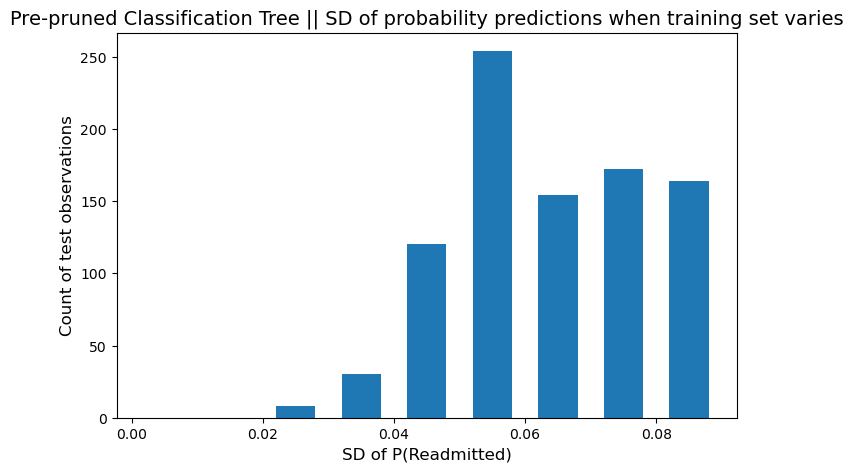

In [59]:
plot_probability_std(best_model_clf, df_train, y_name, x_name, kf10, "Pre-pruned Classification Tree")

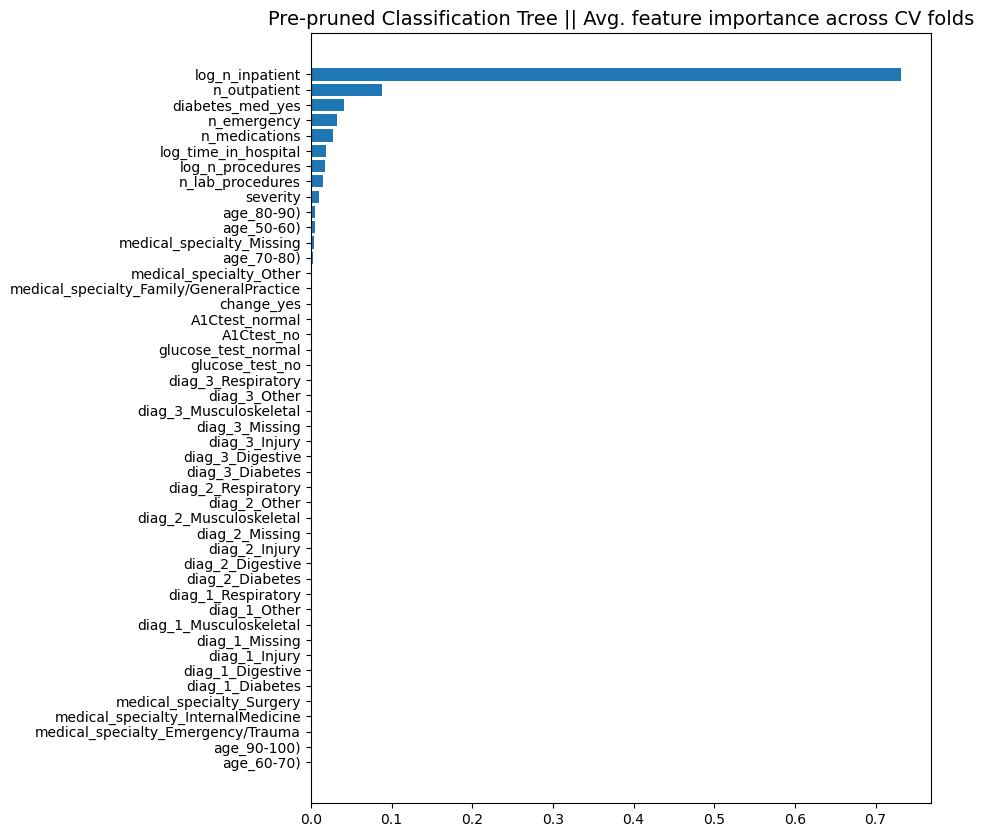

In [60]:
plot_avg_feature_importance(best_model_clf, df_train, y_name, x_name, kf10, "Pre-pruned Classification Tree")

Test AUC: 0.63
Accuracy: 0.60
Confusion Matrix:
[[1721  937]
 [1074 1268]]


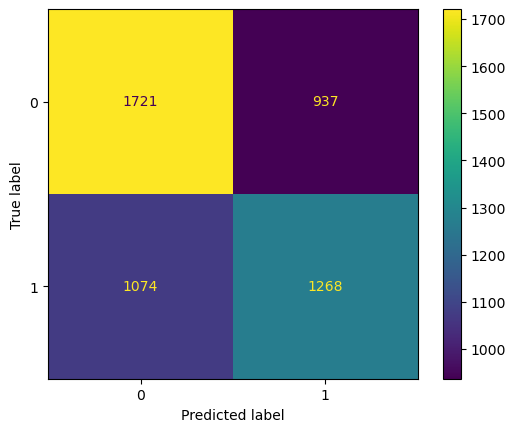

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63      2658
           1       0.58      0.54      0.56      2342

    accuracy                           0.60      5000
   macro avg       0.60      0.59      0.59      5000
weighted avg       0.60      0.60      0.60      5000



In [61]:
evaluate_model(best_model_clf, df_X_test_scaled, df_y_test)

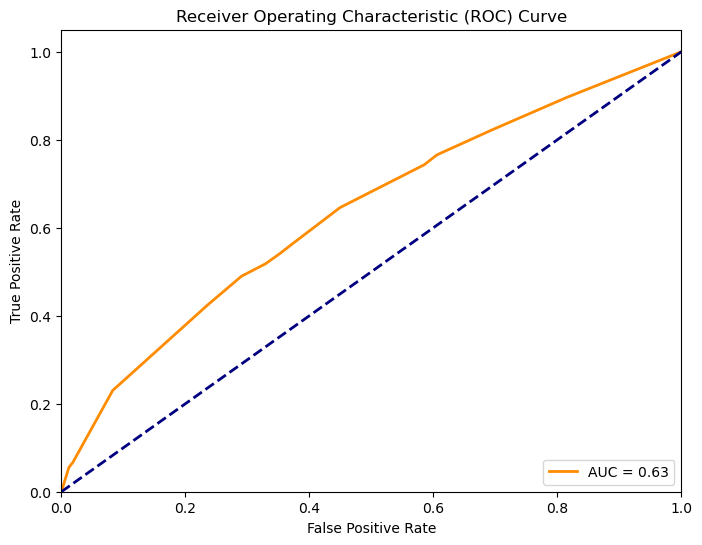

In [62]:
plot_roc_curve(best_model_clf, df_X_test_scaled, df_y_test)

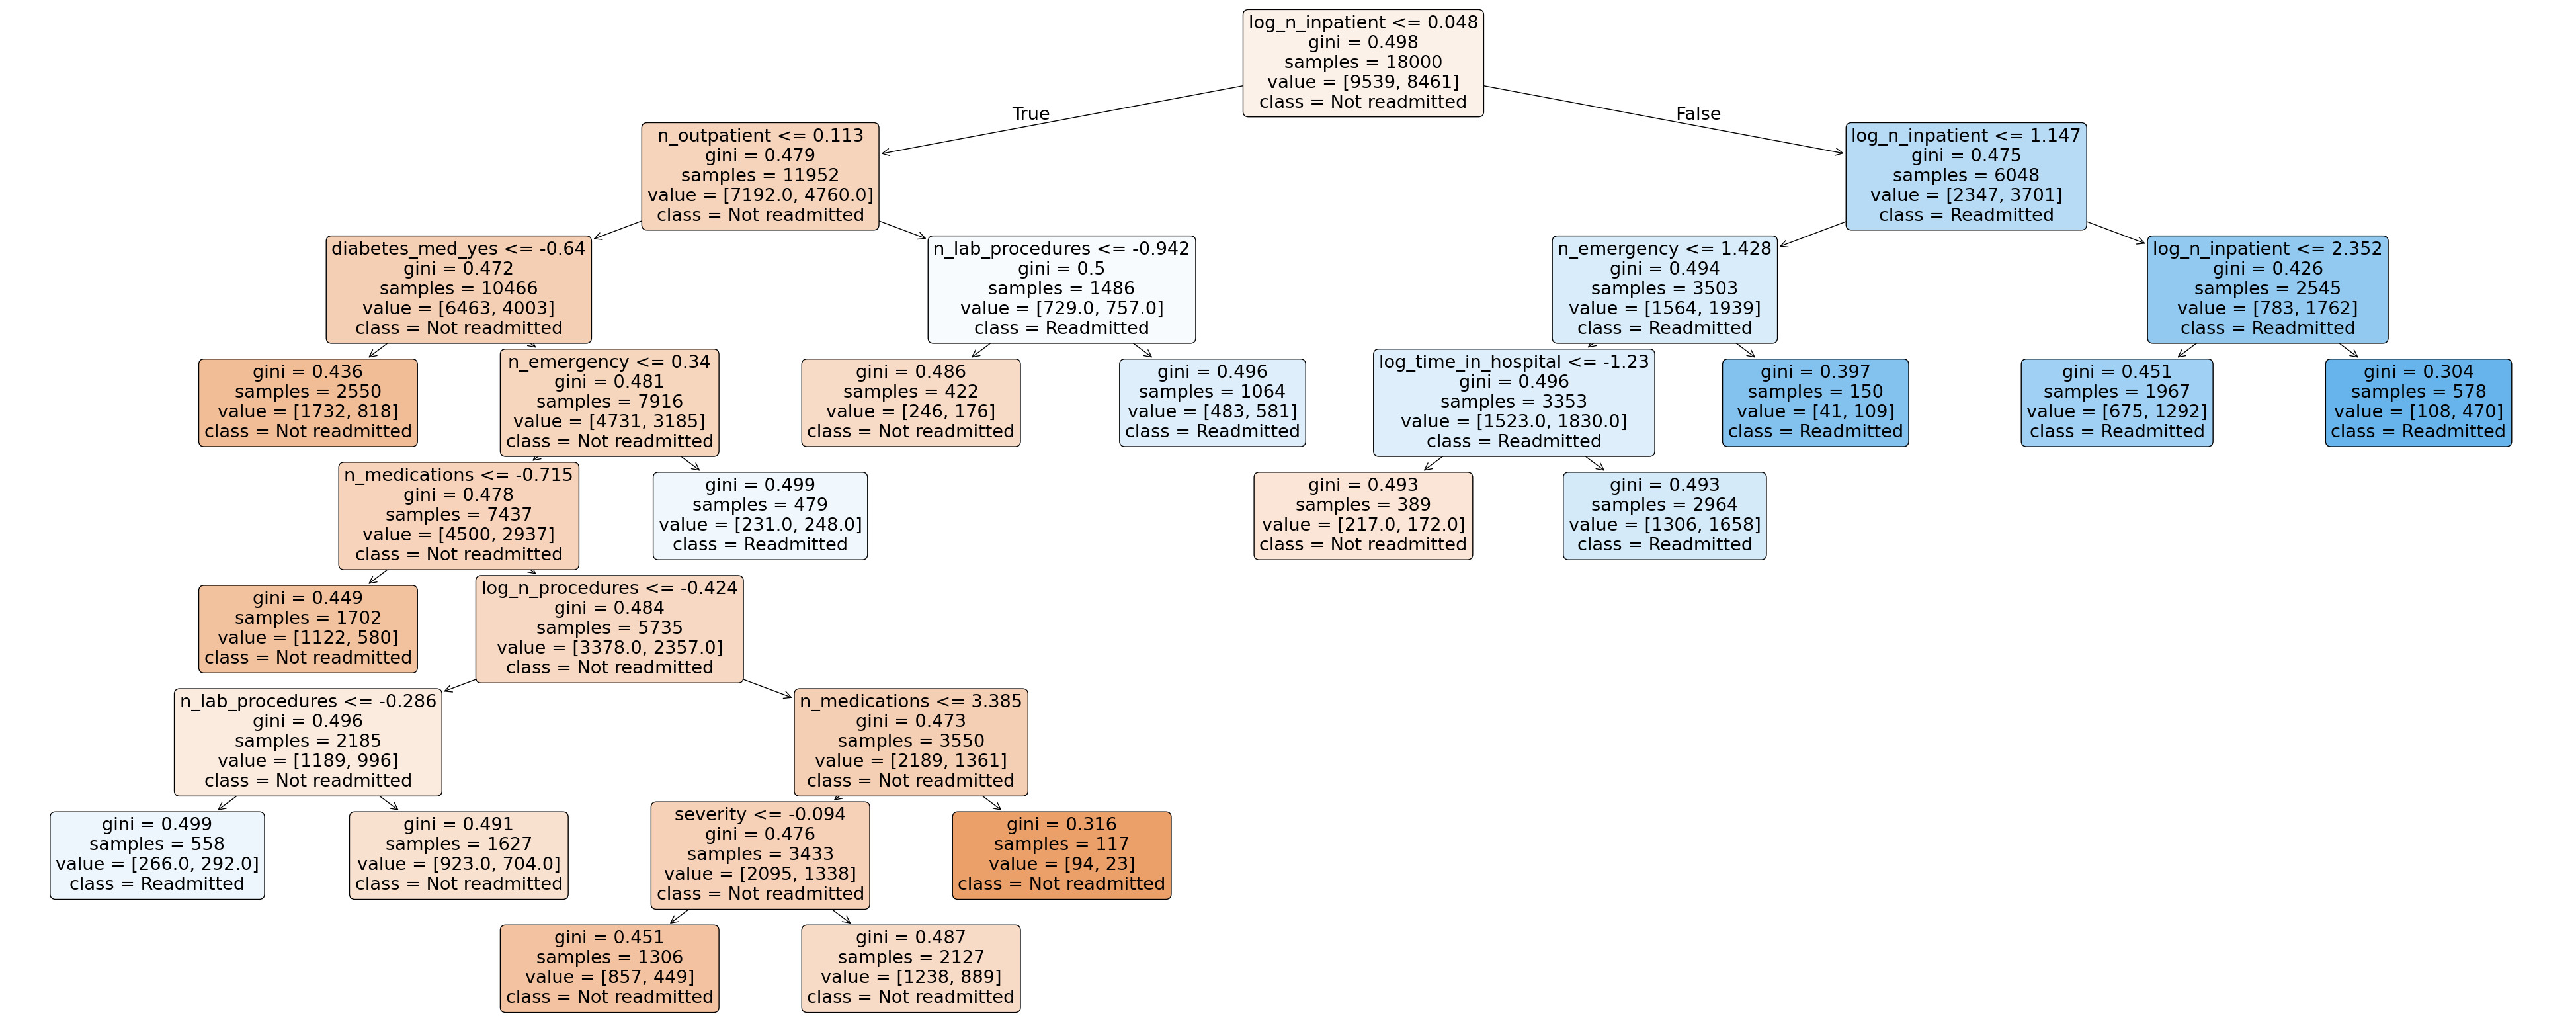

In [63]:
# Plotting the tree
plt.figure(figsize=(50, 20))
plot_tree(best_model_clf, filled=True, feature_names=x_name, class_names=['Not readmitted', 'Readmitted'], rounded=True)
plt.show()

### Post-pruning

In [66]:
# Get effective alphas for pruning
path = classificationtree.cost_complexity_pruning_path(X_train_scaled, y_train)
ccp_alphas=path.ccp_alphas
impurities=path.impurities

# Define the hyperparameter grid
post_prune_param_grid = {
    'ccp_alpha': ccp_alphas
}

# Create a GridSearchCV object
grid_search_post_prune = GridSearchCV(estimator=classificationtree, param_grid=post_prune_param_grid, scoring='roc_auc', cv=kf10, verbose=4, return_train_score=True)

# Fit the GridSearchCV object to the training data
grid_search_post_prune.fit(df_train[x_name], df_train[y_name])

Fitting 10 folds for each of 2446 candidates, totalling 24460 fits
[CV 1/10] END ccp_alpha=0.0;, score=(train=1.000, test=0.535) total time=   0.3s
[CV 2/10] END ccp_alpha=0.0;, score=(train=1.000, test=0.540) total time=   0.3s
[CV 3/10] END ccp_alpha=0.0;, score=(train=1.000, test=0.552) total time=   0.3s
[CV 4/10] END ccp_alpha=0.0;, score=(train=1.000, test=0.528) total time=   0.4s
[CV 5/10] END ccp_alpha=0.0;, score=(train=1.000, test=0.545) total time=   0.4s
[CV 6/10] END ccp_alpha=0.0;, score=(train=1.000, test=0.518) total time=   0.3s
[CV 7/10] END ccp_alpha=0.0;, score=(train=1.000, test=0.518) total time=   0.3s
[CV 8/10] END ccp_alpha=0.0;, score=(train=1.000, test=0.533) total time=   0.3s
[CV 9/10] END ccp_alpha=0.0;, score=(train=1.000, test=0.528) total time=   0.2s
[CV 10/10] END ccp_alpha=0.0;, score=(train=1.000, test=0.533) total time=   0.2s
[CV 1/10] END ccp_alpha=2.666666666666666e-05;, score=(train=1.000, test=0.535) total time=   0.3s
[CV 2/10] END ccp_alpha

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': array([0.00000000e+00, 2.66666667e-05, 2.85714286e-05, ...,
       2.61221640e-03, 3.21384419e-03, 2.00345888e-02])},
             return_train_score=True, scoring='roc_auc', verbose=4)

#### Model Performance

In [68]:
report_GridSearchCV_results(grid_search_post_prune)

- Best combination of hyperparams:
 {'ccp_alpha': 0.0002577008335828551} 

- Best mean_test_score:
 0.6385992855021885 

- Score by fold for best estimator:
 [0.6445609038774083, 0.6429567488600647, 0.64027184707424, 0.6303182836899942, 0.6515900666379598, 0.6506916876817452, 0.6337261049457951, 0.6242858044524325, 0.6286588306845862, 0.6389325771176594] 

- Top 10 hyperparameter combinations by mean_test_score:


mean_test_score  param_ccp_alpha
rank_test_score                                  
1                       0.638599         0.000258
2                       0.637341         0.000241
3                       0.637245         0.000240
4                       0.637043         0.000287
5                       0.636850         0.000333
5                       0.636850         0.000333
7                       0.636076         0.000306
8                       0.635346         0.000233
9                       0.635314         0.000231
10                      0.634850         0.000395

In [69]:
compare_performance(grid_search_post_prune)

train_AUC   val_AUC
1           1.0  0.533032
2           1.0  0.533008
3           1.0  0.533080
4           1.0  0.533080
5           1.0  0.533080
6           1.0  0.533079
7           1.0  0.533079
8           1.0  0.533109
9           1.0  0.533109
10          1.0  0.533109
Mean        1.0  0.533077

In [70]:
best_model_post_prune=grid_search_post_prune.best_estimator_

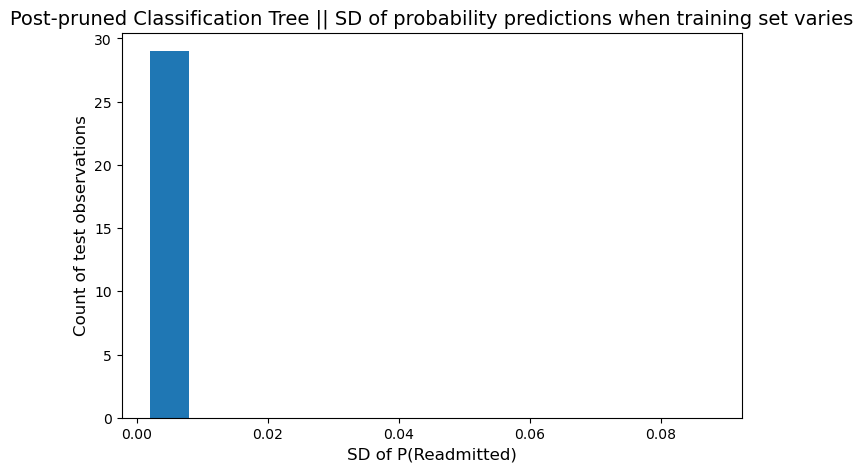

In [71]:
plot_probability_std(best_model_post_prune, df_train, y_name, x_name, kf10, "Post-pruned Classification Tree")

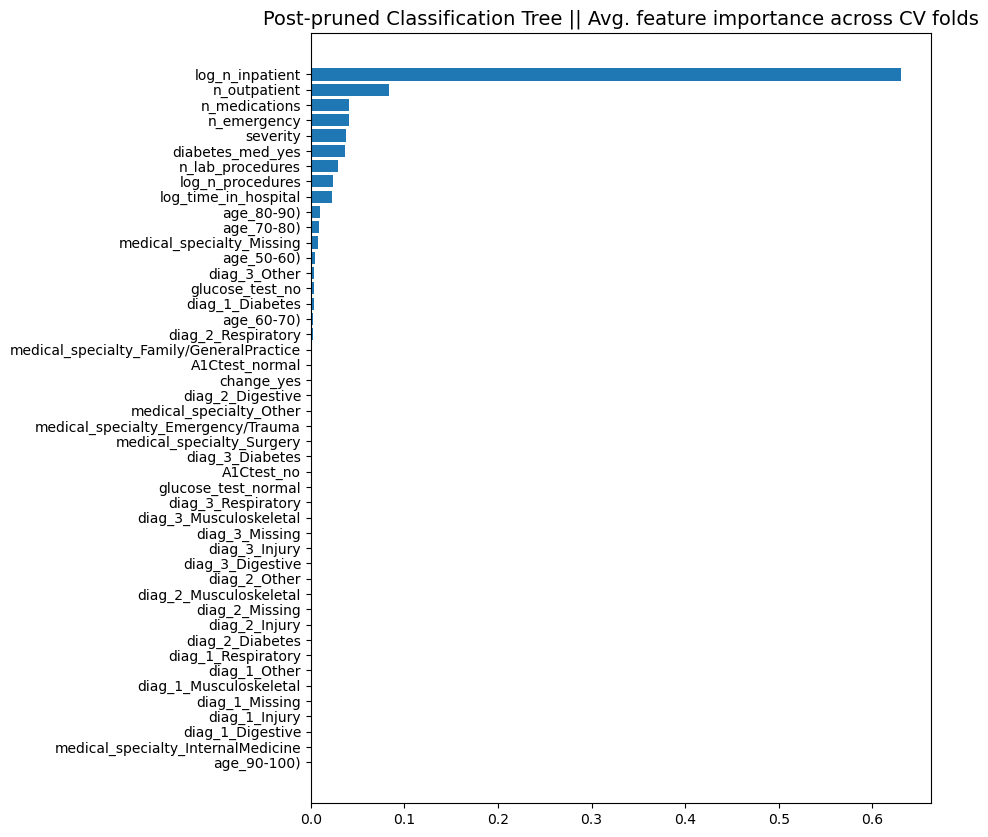

In [72]:
plot_avg_feature_importance(best_model_post_prune, df_train, y_name, x_name, kf10, "Post-pruned Classification Tree")

Test AUC: 0.64
Accuracy: 0.60
Confusion Matrix:
[[1843  815]
 [1179 1163]]


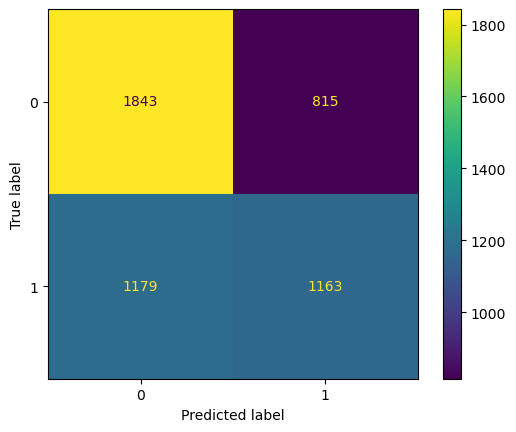

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.69      0.65      2658
           1       0.59      0.50      0.54      2342

    accuracy                           0.60      5000
   macro avg       0.60      0.59      0.59      5000
weighted avg       0.60      0.60      0.60      5000



In [73]:
evaluate_model(best_model_post_prune, df_X_test_scaled, df_y_test)

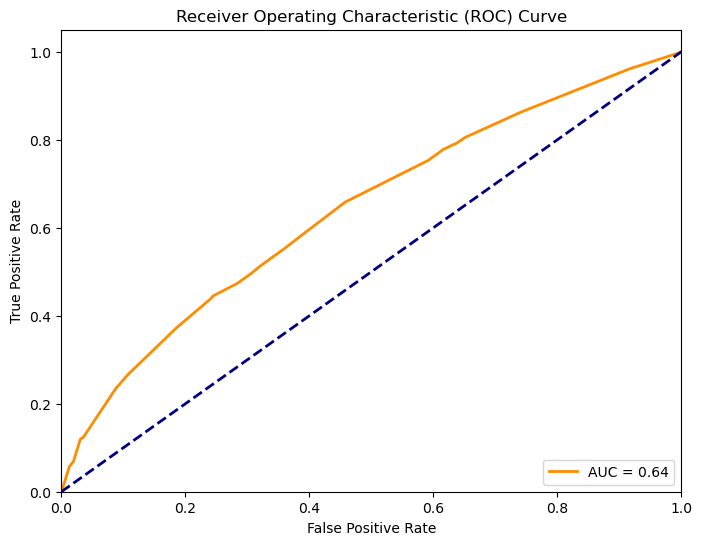

In [74]:
plot_roc_curve(best_model_post_prune, df_X_test_scaled, df_y_test)

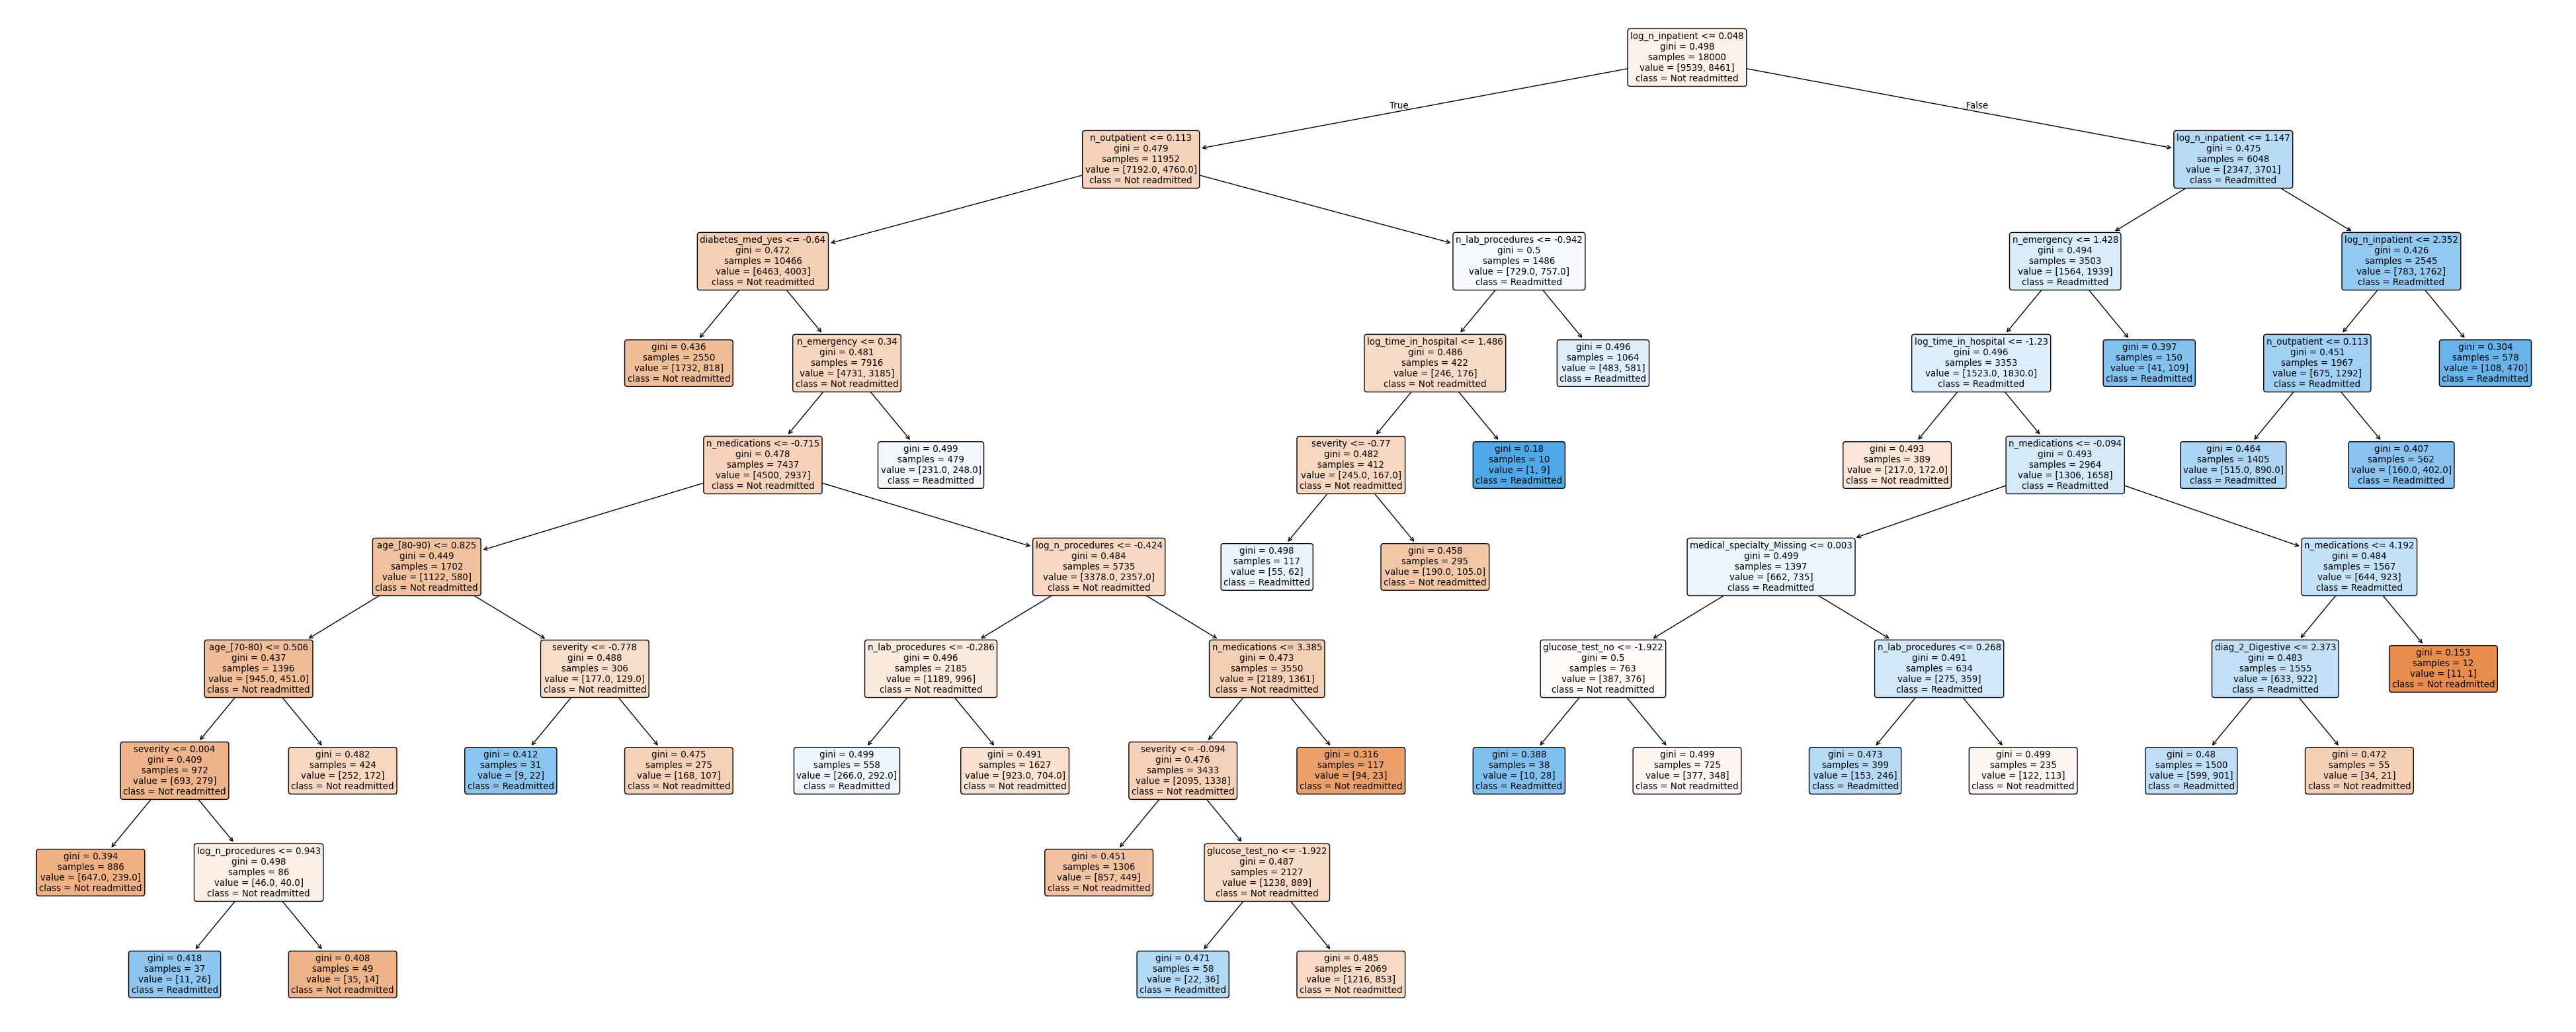

In [75]:
# Plotting the tree
plt.figure(figsize=(50, 20))
plot_tree(best_model_post_prune, filled=True, feature_names=X_train.columns, class_names=['Not readmitted', 'Readmitted'], rounded=True)
plt.show()

## Random Forest Model  (with regularization)

In [84]:
# Initialize model
randomforest = RandomForestClassifier(max_depth = 6, random_state = 42, bootstrap=True)

# Define the hyperparameter grid
rf_param_grid = {
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [500, 1000, 2000],
    'max_features': [2, 3], 
}

# Create a GridSearchCV object
grid_search_rf = GridSearchCV(estimator=randomforest, param_grid=rf_param_grid, cv=kf10, scoring='roc_auc', verbose=4, return_train_score=True)

# Fit the GridSearchCV object to the training data
# To resolve error: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 
# y to (n_samples,), for example using ravel().return fit_method(estimator, *args, **kwargs)
grid_search_rf.fit(df_train[x_name], df_train[y_name].values.ravel())

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END max_depth=2, max_features=2, min_samples_leaf=500;, score=(train=0.639, test=0.639) total time=   0.3s
[CV 2/10] END max_depth=2, max_features=2, min_samples_leaf=500;, score=(train=0.640, test=0.647) total time=   0.3s
[CV 3/10] END max_depth=2, max_features=2, min_samples_leaf=500;, score=(train=0.640, test=0.639) total time=   0.3s
[CV 4/10] END max_depth=2, max_features=2, min_samples_leaf=500;, score=(train=0.642, test=0.615) total time=   0.4s
[CV 5/10] END max_depth=2, max_features=2, min_samples_leaf=500;, score=(train=0.639, test=0.643) total time=   0.5s
[CV 6/10] END max_depth=2, max_features=2, min_samples_leaf=500;, score=(train=0.639, test=0.649) total time=   0.4s
[CV 7/10] END max_depth=2, max_features=2, min_samples_leaf=500;, score=(train=0.641, test=0.635) total time=   0.4s
[CV 8/10] END max_depth=2, max_features=2, min_samples_leaf=500;, score=(train=0.642, test=0.612) total time=   0.3s
[

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(max_depth=6, random_state=42),
             param_grid={'max_depth': [2, 3, 4], 'max_features': [2, 3],
                         'min_samples_leaf': [500, 1000, 2000]},
             return_train_score=True, scoring='roc_auc', verbose=4)

#### Model Performance

In [87]:
report_GridSearchCV_results(grid_search_rf)

- Best combination of hyperparams:
 {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 500} 

- Best mean_test_score:
 0.6409978359812152 

- Score by fold for best estimator:
 [0.6482674781776252, 0.6513156041355608, 0.6480194987161607, 0.6160162023648865, 0.6545420509716655, 0.6511617618076586, 0.6392177577137725, 0.619981345507844, 0.6313241923611761, 0.650132468055802] 

- Top 10 hyperparameter combinations by mean_test_score:


mean_test_score  param_max_depth  param_min_samples_leaf  \
rank_test_score                                                             
1                       0.640998                4                     500   
2                       0.640955                2                     500   
3                       0.640234                3                     500   
4                       0.639044                4                     500   
5                       0.638614                2                    1000   
6                       0.638317                4                    1000   
7                       0.637706                3                     500   
8                       0.637399                3                    1000   
9                       0.634454                2                     500   
10                      0.634365                2                    1000   

                 param_max_features  
rank_test_score                      
1                                 3  
2                                 3  
3                                 3  
4                                 2  
5                                 3  
6                                 3  
7                                 2  
8                                 3  
9                                 2  
10                                2

In [89]:
compare_performance(grid_search_rf)

train_AUC   val_AUC
1      0.640278  0.634454
2      0.639069  0.634365
3      0.623916  0.620221
4      0.646015  0.640955
5      0.643191  0.638614
6      0.625180  0.621237
7      0.643744  0.637706
8      0.639416  0.634266
9      0.623525  0.619434
10     0.646405  0.640234
Mean   0.637074  0.632149

In [91]:
best_model_rf=grid_search_rf.best_estimator_

C:\Users\woowe\anaconda\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\woowe\anaconda\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\woowe\anaconda\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\woowe\anaconda\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

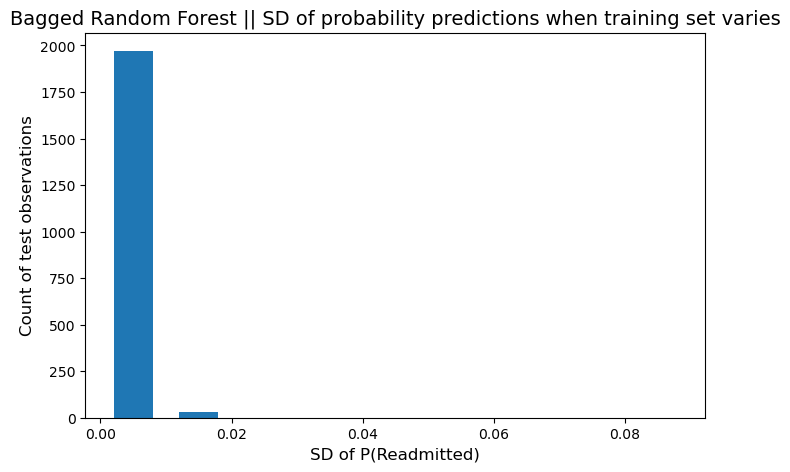

In [95]:
plot_probability_std(best_model_rf, df_train, y_name, x_name, kf10, "Bagged Random Forest")

C:\Users\woowe\anaconda\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\woowe\anaconda\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\woowe\anaconda\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\woowe\anaconda\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

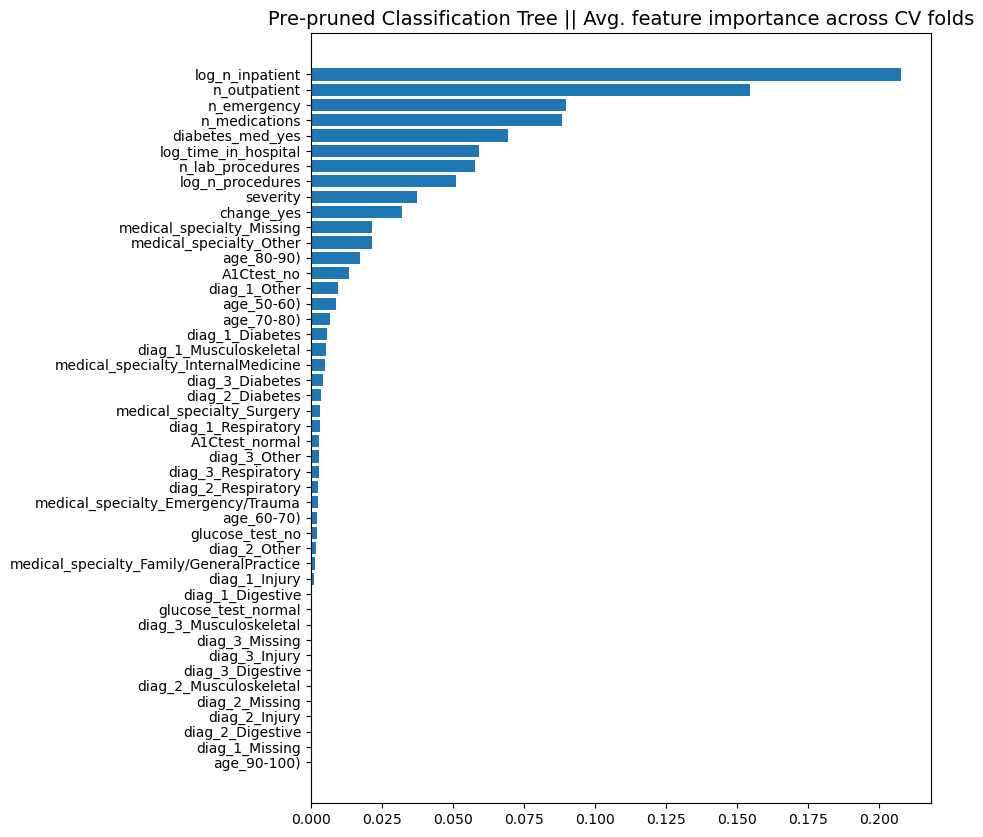

In [99]:
plot_avg_feature_importance(best_model_rf, df_train, y_name, x_name, kf10, "Pre-pruned Classification Tree")

Test AUC: 0.64
Accuracy: 0.59
Confusion Matrix:
[[2344  314]
 [1747  595]]


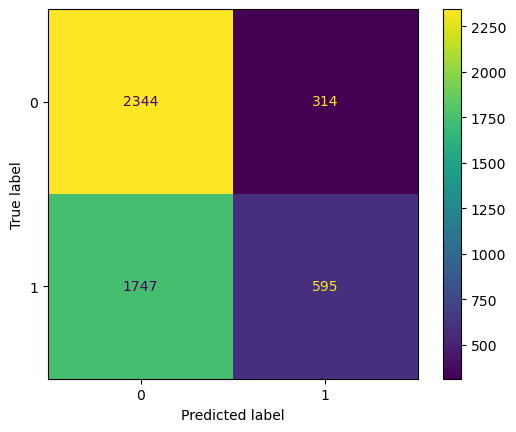

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.88      0.69      2658
           1       0.65      0.25      0.37      2342

    accuracy                           0.59      5000
   macro avg       0.61      0.57      0.53      5000
weighted avg       0.61      0.59      0.54      5000



In [101]:
evaluate_model(best_model_rf, df_X_test_scaled, df_y_test)

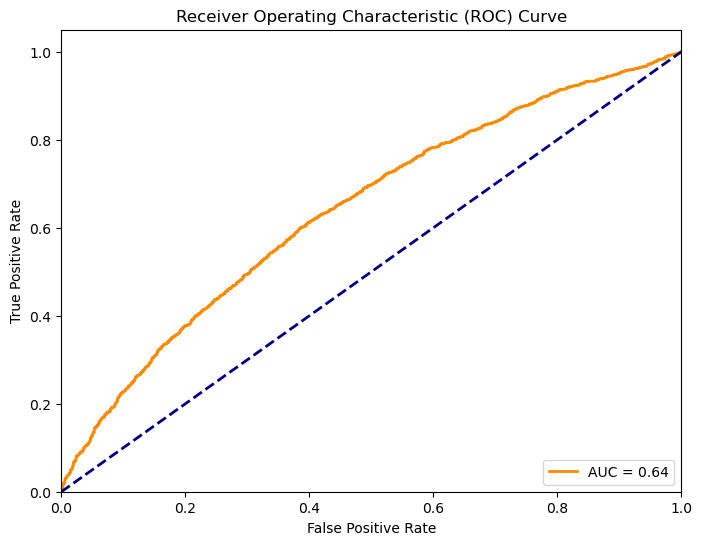

In [103]:
plot_roc_curve(best_model_rf, df_X_test_scaled, df_y_test)

## XGBoost (With regularization)

In [108]:
# Initialize model
xgb_model = xgb.XGBClassifier(random_state = 42)

# Define the hyperparameter grid
xgb_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 10],
    'alpha': [0, 0.1, 1], # Alpha/lasso regularisation
    'lambda': [0, 0.1, 1], # Lambda/ridge regularisation
    'learning_rate': [0.01, 0.05]    
}

# Create a GridSearchCV object
grid_search_xgb = GridSearchCV(param_grid=xgb_param_grid, estimator=xgb_model, 
                        scoring='roc_auc', cv=kf10, verbose=4, return_train_score=True)

# Fit the GridSearchCV object to the training data
grid_search_xgb.fit(df_train[x_name], df_train[y_name])

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
[CV 1/10] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.647, test=0.656) total time=   0.1s
[CV 2/10] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.649, test=0.654) total time=   0.0s
[CV 3/10] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.647, test=0.648) total time=   0.0s
[CV 4/10] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.651, test=0.621) total time=   0.0s
[CV 5/10] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.647, test=0.653) total time=   0.0s
[CV 6/10] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.647, test=0.660) total time= 

C:\Users\woowe\anaconda\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     in...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'alpha': [0, 0.1, 1], 'colsample_bytree': [0.3, 0.7],
                         'lambda': [0, 0.1, 1], 'learning_rate': [0.01, 0.05],
                         'max_depth': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=4)

#### Model Performance

In [110]:
report_GridSearchCV_results(grid_search_xgb)

- Best combination of hyperparams:
 {'alpha': 1, 'colsample_bytree': 0.3, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200} 

- Best mean_test_score:
 0.6574395398994423 

- Score by fold for best estimator:
 [0.6630527191725473, 0.6624372683405841, 0.6663100724985688, 0.6403077003405951, 0.6622020538423473, 0.6628095450687967, 0.6601580040413113, 0.6475613409193599, 0.649832697452752, 0.6597239973175595] 

- Top 10 hyperparameter combinations by mean_test_score:


mean_test_score  param_colsample_bytree  param_n_estimators  \
rank_test_score                                                                
1                       0.657440                     0.3                 200   
2                       0.656978                     0.3                 200   
3                       0.656880                     0.3                 200   
4                       0.656737                     0.3                 200   
5                       0.656657                     0.3                 200   
6                       0.656594                     0.3                 200   
7                       0.656527                     0.3                 200   
8                       0.656452                     0.3                 200   
9                       0.656324                     0.3                 200   
10                      0.655983                     0.7                 200   

                 param_max_depth  param_alpha  param_lambda  \
rank_test_score                                               
1                              5          1.0           1.0   
2                              5          1.0           0.1   
3                              5          1.0           0.0   
4                              5          0.0           0.0   
5                              5          0.0           0.1   
6                              5          0.1           1.0   
7                              5          0.0           1.0   
8                              5          0.1           0.0   
9                              5          0.1           0.1   
10                             5          0.1           0.1   

                 param_learning_rate  
rank_test_score                       
1                               0.05  
2                               0.05  
3                               0.05  
4                               0.05  
5                               0.05  
6                               0.05  
7                               0.05  
8                               0.05  
9                               0.05  
10                              0.05

In [111]:
compare_performance(grid_search_xgb)

train_AUC   val_AUC
1      0.648459  0.644285
2      0.650600  0.646056
3      0.652415  0.647117
4      0.679256  0.652434
5      0.684090  0.653665
6      0.690959  0.655600
7      0.813134  0.649548
8      0.829279  0.651748
9      0.851257  0.653650
10     0.651624  0.646783
Mean   0.715107  0.650089

In [112]:
best_model_xgb=grid_search_xgb.best_estimator_

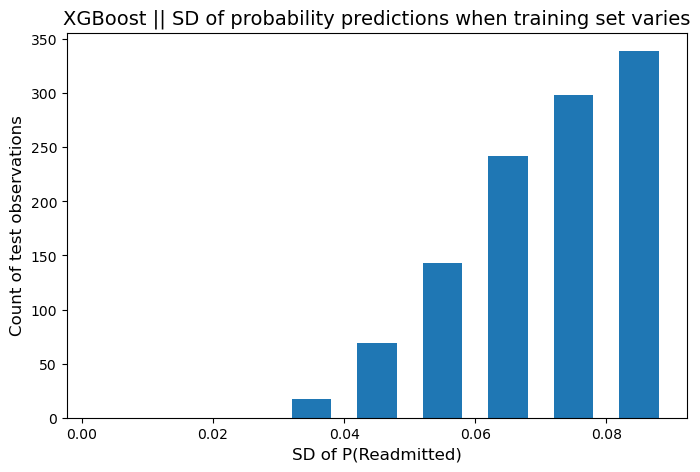

In [113]:
plot_probability_std(best_model_xgb, df_train, y_name, x_name, kf10, "XGBoost")

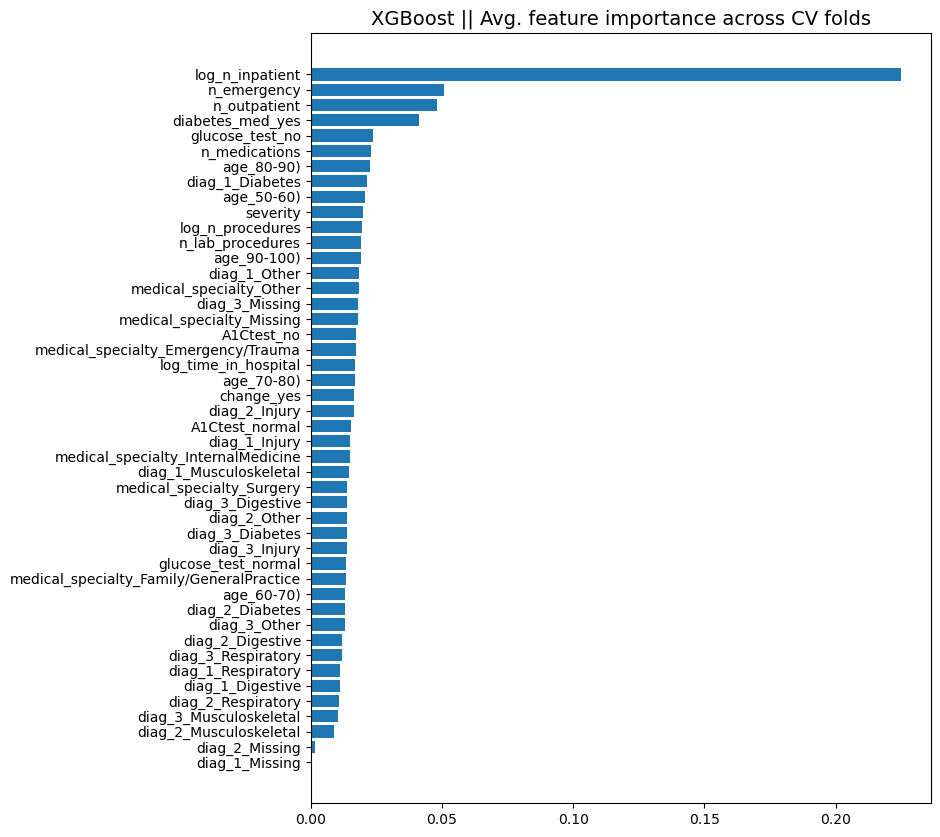

In [114]:
plot_avg_feature_importance(best_model_xgb, df_train, y_name, x_name, kf10, "XGBoost")

Test AUC: 0.66
Accuracy: 0.62
Confusion Matrix:
[[1984  674]
 [1216 1126]]


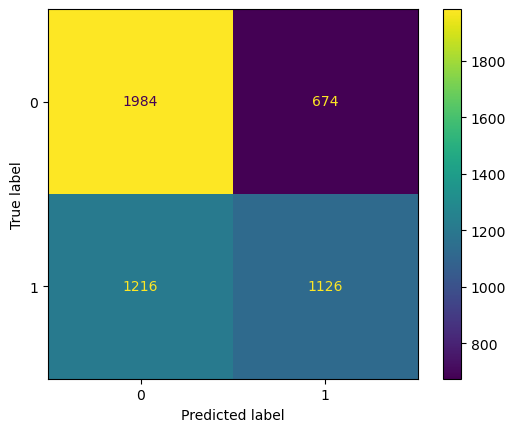

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68      2658
           1       0.63      0.48      0.54      2342

    accuracy                           0.62      5000
   macro avg       0.62      0.61      0.61      5000
weighted avg       0.62      0.62      0.61      5000



In [115]:
evaluate_model(best_model_xgb, df_X_test_scaled, df_y_test)

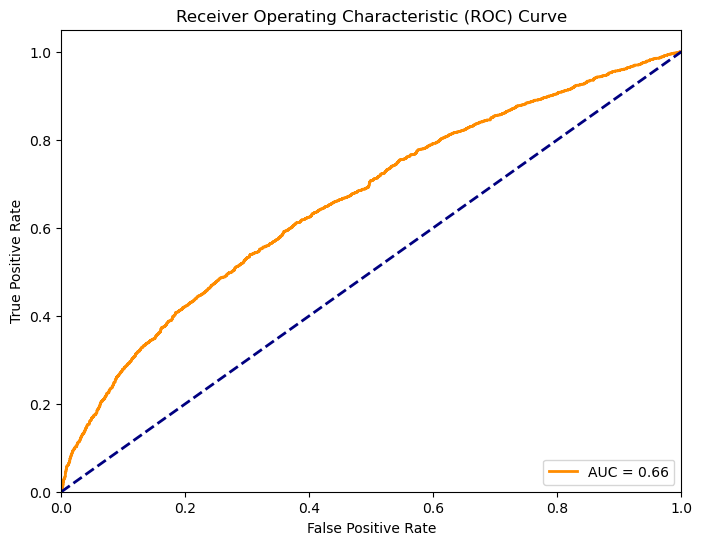

In [116]:
plot_roc_curve(best_model_xgb, df_X_test_scaled, df_y_test)